# Set up access to database

In [ ]:
# sets *your* project id
PROJECT_ID = "sylvan-weft-405211" #@param {type:"string"}

# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_0_2' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

In [ ]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


# Imports

In [ ]:
!pip install amsterdamumcdb

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import amsterdamumcdb as adb

# Set up notebook to right display of data and SQL queries

In [ ]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 150

In [ ]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config

# Set up config

In [ ]:
config_gbq = {'query':
                {'defaultDataset': {
                    "datasetId": DATASET_ID,
                    "projectId": DATASET_PROJECT_ID
                    },
                'Location': LOCATION}
           }

# Extract data

## Info about cohort

Paper for sepsis cohort criteria:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9650242/

Sepsis-3

The third consensus definition of sepsis, by the Sepsis-3 Task Force, recommended a revised definition to address and ameliorate previous limitations and to allow for greater consistency in operationalising the definition criteria across different centres. Nevertheless, there is not unanimous agreement within the intensive care community on the utility of the new definition. The Sepsis-3 clinical criteria are an acute increase in Sequential Organ Failure Assessment (SOFA) of at least 2 points, accompanying a suspected or documented infection, with the criteria for septic shock further requiring both use of vasopressors and a lactate level >2 mmol/L. SOFA measures the severity of organ dysfunction across the six domains of the respiratory, neurological, cardiovascular, liver, coagulation and renal systems.

Sepsis-3 in Amsterdam UMC database

We provide a single script that computes the following: daily SOFA scores (individual components and total score) for each admission, antibiotic escalation on a daily basis, and finally sepsis/septic shock episodes (where one ‘day’ corresponds to each 24 h period after admission). Our definition of each SOFA component score follows the AmsterdamUMCdb SOFA script, and we extend this computation from just the 24 h period post admission to a longer time period spanning multiple ‘days’. This time period may be specified early within our script. Where no SOFA scores were available prior to ICU admission, the SOFA components were assumed to be zero, as per the Sepsis-3 recommendation. However, at least three missing SOFA components resulted in discarding any identification of sepsis or not for that admission/day.

## Code

In [ ]:
sepsis_cohort = adb.get_sepsis_patients(config_gbq) # Returns a dataframe containing patients with a diagnosis of sepsis at admission.
sepsis_cohort.shape

Creating cohort Sepsis-3 at admission (infection and SOFA score ≥2)...
Querying reason for admission...
Selecting patients with presumed infection...
Selecting patients based on SOFA total score SOFA ≥2
Starting SOFA at admission...
Querying admissions...
Querying SOFA Respiration...
Processing SOFA Respiration...
Querying SOFA Coagulation...
Processing SOFA Coagulation...
Querying SOFA Liver...
Processing SOFA Liver...
Querying SOFA Cardiovascular: vasopressors/inotropes...
Processing SOFA Cardiovascular: vasopressors/inotropes...
Querying SOFA Cardiovascular: MAP...
Processing SOFA Cardiovascular: MAP...
Querying SOFA Central nervous system...
Processing SOFA Central nervous system...
Querying SOFA Renal: urine output...
Processing SOFA Renal: urine output...
Querying SOFA Renal: creatinine...
Processing SOFA Renal: creatinine...
Merging SOFA Scores...
SOFA processing complete.


(3019, 41)

In [ ]:
sepsis_cohort.columns

Index(['patientid', 'admissionid', 'admissioncount', 'location', 'urgency',
       'origin', 'admittedat', 'admissionyeargroup', 'dischargedat',
       'lengthofstay', 'destination', 'gender', 'agegroup', 'dateofdeath',
       'weightgroup', 'weightsource', 'heightgroup', 'heightsource',
       'specialty', 'diagnosis_type', 'diagnosis', 'diagnosis_id',
       'diagnosis_subgroup', 'diagnosis_subgroup_id', 'diagnosis_group',
       'diagnosis_group_id', 'surgical', 'sepsis_at_admission',
       'sepsis_antibiotics_bool', 'sepsis_antibiotics_given',
       'other_antibiotics_bool', 'other_antibiotics_given',
       'sepsis_cultures_bool', 'sepsis_cultures_drawn',
       'sofa_respiration_score', 'sofa_coagulation_score', 'sofa_liver_score',
       'sofa_cardiovascular_score', 'sofa_cns_score', 'sofa_renal_score',
       'sofa_total_score'],
      dtype='object')

In [ ]:
# save column names as csv file for future work
pd.DataFrame({'': sepsis_cohort.columns}).to_csv(
                                            'column_names.csv',
                                            index=False,
                                            header=False
                                          )

In [ ]:
sepsis_cohort.head(10)

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,...,other_antibiotics_given,sepsis_cultures_bool,sepsis_cultures_drawn,sofa_respiration_score,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score
0,11,11,1,IC,1,None,0,2003-2009,148620000,42,...,None,1,Legionella sneltest (urine),2.0,2.0,1.0,4.0,NaN,4.0,13.0
1,19,20,1,IC,1,None,0,2003-2009,605100000,168,...,Amoxicilline/Clavulaanzuur (Augmentin),1,Bloedkweken afnemen,2.0,1.0,0.0,1.0,NaN,1.0,5.0
2,24,25,1,MC,0,None,0,2003-2009,247020000,69,...,None,<NA>,None,2.0,2.0,4.0,3.0,NaN,2.0,13.0
3,41,44,1,IC,0,None,0,2003-2009,77220000,21,...,Vancomycine,<NA>,None,2.0,4.0,2.0,1.0,NaN,0.0,9.0
4,43,47,2,IC,1,Verpleegafdeling zelfde ziekenhuis,166080000,2010-2016,562560000,110,...,None,<NA>,None,2.0,1.0,0.0,4.0,0.0,3.0,10.0
5,46,50,1,IC,0,None,0,2003-2009,3158160000,878,...,None,<NA>,None,2.0,1.0,2.0,4.0,NaN,0.0,9.0
6,54,58,1,IC&MC,1,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,340800000,95,...,Metronidazol (Flagyl),<NA>,None,2.0,0.0,0.0,4.0,0.0,2.0,8.0
7,61,66,1,IC,0,None,0,2003-2009,1144080000,318,...,Metronidazol (Flagyl),<NA>,None,2.0,0.0,0.0,3.0,NaN,0.0,5.0
8,65,70,1,IC,0,None,0,2003-2009,112560000,32,...,Metronidazol (Flagyl),<NA>,None,1.0,1.0,1.0,3.0,NaN,1.0,7.0
9,68,76,1,IC,1,Verpleegafdeling zelfde ziekenhuis,0,2010-2016,121260000,34,...,Metronidazol (Flagyl),<NA>,None,2.0,0.0,NaN,0.0,0.0,0.0,2.0


In [ ]:
dictionary = adb.get_dictionary()
dictionary.head()

,itemid,item,item_en,vocabulary_id,vocabulary_concept_code,vocabulary_concept_name,abbreviation,categoryid,category,category_en,...,unitid,unit,ucum_code,low_normal_value,high_normal_value,expected_min_value,expected_max_value,table,count,count_validated
0,6637,Opname gewicht,NaN,NaN,NaN,NaN,GewichtOpname,466,Patientenbestandparameters,NaN,...,12.0,kg,kg,NaN,NaN,NaN,NaN,numericitems,2609,2609.0
1,6638,Huidig gewicht,NaN,NaN,NaN,NaN,GewichtX,328,OLGV-OUD,NaN,...,12.0,kg,kg,NaN,NaN,NaN,NaN,numericitems,2751,2751.0
2,6640,Hartfrequentie,heart rate,LOINC,76282-3,Heart rate.beat-to-beat by EKG,HF,320,HD-Hartritme,hemodynamics-heart rhythm,...,15.0,/min,/min,80,120,1.0,250.0,numericitems,37732398,2218626.0
3,6641,ABP systolisch,invasive systolic arterial pressure,LOINC,76215-3,Invasive Systolic blood pressure,ABPs,323,HD-Bloeddrukken,hemodynamics-blood pressures,...,173.0,mmHg,mm[Hg],80,160,40.0,250.0,numericitems,33343613,2109758.0
4,6642,ABP gemiddeld,invasive mean arterial pressure,LOINC,76214-6,Invasive Mean blood pressure,ABPm,323,HD-Bloeddrukken,hemodynamics-blood pressures,...,173.0,mmHg,mm[Hg],50,120,30.0,250.0,numericitems,33352770,2109165.0


In [ ]:
admissionids = sepsis_cohort.admissionid.unique()
admissionids

<IntegerArray>
[   11,    20,    25,    44,    47,    50,    58,    66,    70,    76,
 ...
 23470, 23472, 23476, 23480, 23482, 23483, 23488, 23514, 23535, 23540]
Length: 3019, dtype: Int64

# Extract common measurements

### Settings

In [ ]:
# set up measurements window from admission date
measurement_window = 24 * 100 # 100 days

In [ ]:
measurements_list = []

In [ ]:
itemid_to_name = dict()

In [ ]:
# aggregating measurementd for time_window
time_window = 60 * 4

## Extract heart rate

itemid:
- 6640 --Hartfrequentie

In [ ]:
itemid_to_name[6640] = 'heartrate'

In [ ]:
# get heart frequency
heart_frequency = pd.read_gbq(
    f'''
    SELECT
        n.admissionid,
        n.itemid,
        n.item,
        n.value,
        CASE
            WHEN NOT registeredby IS NULL THEN TRUE
            ELSE FALSE
        END as validated,
        (measuredat - a.admittedat)/(1000*60) AS time --in minutes
    FROM numericitems n
    LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE itemid IN (
        6640 --Hartfrequentie
    )
    AND (measuredat - a.admittedat) <= 1000*60*60*{measurement_window} --measurements within measuring_window hours
        '''
        , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of heartfrequences values: {len(heart_frequency)}')

#show first 25 items
heart_frequency.head(10)

Number of heartfrequences values: 2206836


,admissionid,itemid,item,value,validated,time
0,23150,6640,Hartfrequentie,72.0,True,14516.0
1,23043,6640,Hartfrequentie,130.0,True,910.0
2,23299,6640,Hartfrequentie,76.0,True,3435.0
3,23044,6640,Hartfrequentie,80.0,True,939.0
4,23044,6640,Hartfrequentie,65.0,True,2319.0
5,23300,6640,Hartfrequentie,82.0,True,4561.0
6,23045,6640,Hartfrequentie,78.0,True,174.0
7,23045,6640,Hartfrequentie,72.0,True,234.0
8,23303,6640,Hartfrequentie,90.0,True,11.0
9,23048,6640,Hartfrequentie,84.0,True,13659.0


In [ ]:
measurements_list.append(heart_frequency)

## Extract arterial pressure

itemid:
- 6678 -- Niet invasieve bloeddruk systolisch
- 6679 -- Niet invasieve bloeddruk gemiddeld
- 6680 -- Niet invasieve bloeddruk diastolisch


- 6642 -- ABP gemiddeld
- 8843 -- ABP gemiddeld II
- 6641 -- ABP systolisch
- 8841 -- ABP systolisch II
- 6643 -- ABP diastolisch
- 8842 -- ABP diastolisch II


In [ ]:
# itemid_to_name[6678] = 'not_inv_sys_BP'
# itemid_to_name[6679] = 'not_inv_mean_BP'
# itemid_to_name[6680] = 'not_inv_dia_BP'
itemid_to_name[6642] = 'mean_BP'
# itemid_to_name[8843] = 'mean_BP_2'
itemid_to_name[6641] = 'sys_BP'
# itemid_to_name[8841] = 'sys_BP_2'
itemid_to_name[6643] = 'dia_BP'
# itemid_to_name[8842] = 'dia_BP_2'

In [ ]:
dictionary[dictionary['vocabulary_concept_code'] == '76214-6']

,itemid,item,item_en,vocabulary_id,vocabulary_concept_code,vocabulary_concept_name,abbreviation,categoryid,category,category_en,...,unitid,unit,ucum_code,low_normal_value,high_normal_value,expected_min_value,expected_max_value,table,count,count_validated
4,6642,ABP gemiddeld,invasive mean arterial pressure,LOINC,76214-6,Invasive Mean blood pressure,ABPm,323,HD-Bloeddrukken,hemodynamics-blood pressures,...,173.0,mmHg,mm[Hg],50,120,30.0,250.0,numericitems,33352770,2109165.0
869,8843,ABP gemiddeld II,invasive mean arterial pressure,LOINC,76214-6,Invasive Mean blood pressure,ABPm II,367,HD-Overig,hemodynamics-other,...,173.0,mmHg,mm[Hg],NaN,NaN,30.0,250.0,numericitems,56028,1817.0


In [ ]:
# get heart frequency
arterial_preassure = pd.read_gbq(
    f'''
    SELECT
        n.admissionid,
        n.itemid,
        n.item,
        n.value,
        CASE
            WHEN NOT registeredby IS NULL THEN TRUE
            ELSE FALSE
        END as validated,
        (measuredat - a.admittedat)/(1000*60) AS time
    FROM numericitems n
    LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE itemid IN (
        -- 6678, -- Niet invasieve bloeddruk systolisch
        -- 6679, -- Niet invasieve bloeddruk gemiddeld
        -- 6680, -- Niet invasieve bloeddruk diastolisch
        6642, -- ABP gemiddeld
        -- 8843, -- ABP gemiddeld II
        6641, -- ABP systolisch
        -- 8841, -- ABP systolisch II
        6643 -- ABP diastolisch
        -- 8842 -- ABP diastolisch II
    )
    AND (measuredat - a.admittedat) <= 1000*60*60*{measurement_window}
        '''
        , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of arterial preassure values: {len(arterial_preassure)}')

#show first 25 items
arterial_preassure.head(25)

Number of arterial preassure values: 6294336


,admissionid,itemid,item,value,validated,time
0,22538,6643,ABP diastolisch,0.0,True,51.0
1,22538,6643,ABP diastolisch,0.0,True,30540.0
2,22538,6643,ABP diastolisch,0.0,True,17580.0
3,22287,6643,ABP diastolisch,0.0,True,55.0
4,21271,6643,ABP diastolisch,0.0,True,219.0
5,23328,6643,ABP diastolisch,0.0,True,51.0
6,22307,6643,ABP diastolisch,0.0,True,42.0
7,22565,6643,ABP diastolisch,0.0,True,119.0
8,23335,6643,ABP diastolisch,0.0,True,1079.0
9,22568,6643,ABP diastolisch,0.0,True,45639.0


In [ ]:
measurements_list.append(arterial_preassure)

## Extract saturation and respiratory rate

In [ ]:
dictionary[dictionary['vocabulary_concept_code'] == '59408-5']

,itemid,item,item_en,vocabulary_id,vocabulary_concept_code,vocabulary_concept_name,abbreviation,categoryid,category,category_en,...,unitid,unit,ucum_code,low_normal_value,high_normal_value,expected_min_value,expected_max_value,table,count,count_validated
82,6709,Saturatie (Monitor),oxygen saturation SpO2,LOINC,59408-5,Oxygen saturation in Arterial blood by Pulse o...,Saturatie Monitor,586,RESP-Servo Patiëntgegevens,NaN,...,0.0,None,NaN,NaN,NaN,NaN,NaN,numericitems,36411768,2076750.0


In [ ]:
dictionary[dictionary['vocabulary_concept_code'] == '9279-1']

,itemid,item,item_en,vocabulary_id,vocabulary_concept_code,vocabulary_concept_name,abbreviation,categoryid,category,category_en,...,unitid,unit,ucum_code,low_normal_value,high_normal_value,expected_min_value,expected_max_value,table,count,count_validated
894,8874,Ademfrequentie Monitor,respiratory rate monitor,LOINC,9279-1,Respiratory rate,Ademfreq. (Monitor),586,RESP-Servo Patiëntgegevens,NaN,...,0.0,None,NaN,NaN,NaN,NaN,NaN,numericitems,25776086,857738.0


In [ ]:
itemid_to_name[6709] = 'saturation'
itemid_to_name[8874] = 'resp_rate'

In [ ]:
# get heart frequency
saturation = pd.read_gbq(
    f'''
    SELECT
        n.admissionid,
        n.itemid,
        n.item,
        n.value,
        CASE
            WHEN NOT registeredby IS NULL THEN TRUE
            ELSE FALSE
        END as validated,
        (measuredat - a.admittedat)/(1000*60) AS time
    FROM numericitems n
    LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE itemid IN (
        6709, -- Saturatie (Monitor)
        8874  -- Ademfrequentie Monitor
    )
    AND (measuredat - a.admittedat) <= 1000*60*60*{measurement_window} --measurements within measurement_window
    '''
        , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of saturation values: {len(saturation)}')

#show first 25 items
saturation.head(10)

Number of saturation values: 2918663


,admissionid,itemid,item,value,validated,time
0,22784,8874,Ademfrequentie Monitor,14.0,True,2947.0
1,22784,8874,Ademfrequentie Monitor,20.0,True,2407.0
2,22784,8874,Ademfrequentie Monitor,22.0,True,67.0
3,22784,8874,Ademfrequentie Monitor,20.0,True,3007.0
4,22784,8874,Ademfrequentie Monitor,15.0,True,2887.0
5,22784,8874,Ademfrequentie Monitor,22.0,True,2467.0
6,22784,8874,Ademfrequentie Monitor,19.0,True,2827.0
7,22784,8874,Ademfrequentie Monitor,13.0,True,2306.0
8,22784,8874,Ademfrequentie Monitor,18.0,True,3067.0
9,22784,8874,Ademfrequentie Monitor,16.0,True,2347.0


In [ ]:
measurements_list.append(saturation)

## Extract temperature

In [ ]:
codes = ['60834-9', '39106-0', '76278-1', '60836-4', '8332-9', '8328-7', '415929009']
dictionary[dictionary['vocabulary_concept_code'].isin(codes)]

,itemid,item,item_en,vocabulary_id,vocabulary_concept_code,vocabulary_concept_name,abbreviation,categoryid,category,category_en,...,unitid,unit,ucum_code,low_normal_value,high_normal_value,expected_min_value,expected_max_value,table,count,count_validated
664,8658,Temp Bloed,blood temperature,LOINC,60834-9,Blood temperature,Temp Bloed,322,HD-Temperatuur,hemodynamics-temperature,...,59.0,°C,Cel,NaN,NaN,NaN,NaN,numericitems,1999754,196894.0
3566,13058,Temp Rectaal,rectal temperature,LOINC,8332-9,Rectal temperature,Temp Rectaal,322,HD-Temperatuur,hemodynamics-temperature,...,59.0,°C,Cel,NaN,NaN,NaN,NaN,numericitems,387259,34195.0
3567,13059,Temp Lies,groin temperature,SNOMED CT,415929009,Groin temperature,Temp Lies,322,HD-Temperatuur,hemodynamics-temperature,...,59.0,°C,Cel,NaN,NaN,NaN,NaN,numericitems,89321,89321.0
3568,13060,Temp Axillair,axillary temperature,LOINC,8328-7,Axillary temperature,Temp Axillair,322,HD-Temperatuur,hemodynamics-temperature,...,59.0,°C,Cel,NaN,NaN,NaN,NaN,numericitems,202198,202198.0
3571,13063,Temp Huid,skin temperature,LOINC,39106-0,Temperature of Skin,Temp Huid,322,HD-Temperatuur,hemodynamics-temperature,...,59.0,°C,Cel,NaN,NaN,NaN,NaN,numericitems,1948535,34859.0
3912,13952,Temp Blaas,bladder temperature,LOINC,76278-1,Bladder temperature via Foley,Temp Blaas,322,HD-Temperatuur,hemodynamics-temperature,...,59.0,°C,Cel,NaN,NaN,NaN,NaN,numericitems,927689,16029.0
4957,16110,Temp Oesophagus,esophageal temperature,LOINC,60836-4,Esophageal temperature,Temp Oesophagus,322,HD-Temperatuur,hemodynamics-temperature,...,59.0,°C,Cel,NaN,NaN,NaN,NaN,numericitems,833973,46044.0


In [ ]:
itemid_to_name[13058] = 'temp_rect'
itemid_to_name[13059] = 'temp_lies'
itemid_to_name[13060] = 'temp_axil'
itemid_to_name[13063] = 'temp_huid'
itemid_to_name[13952] = 'temp_blaas'
itemid_to_name[16110] = 'temp_oes'
itemid_to_name[8658] = 'temp_bloed'

In [ ]:
# get heart frequency
temperature = pd.read_gbq(
    f'''
    SELECT
        n.admissionid,
        n.itemid,
        n.item,
        n.value,
        CASE
            WHEN NOT registeredby IS NULL THEN TRUE
            ELSE FALSE
        END as validated,
        (measuredat - a.admittedat)/(1000*60) AS time
    FROM numericitems n
    LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE itemid IN (
        -- 8658,  -- Temp Bloed
        -- 13058, -- Temp Rectaal
        -- 13059, -- Temp Lies
        13060 -- Temp Axillair
        -- 13063, -- Temp Huid
        -- 13952, -- Temp Blaas
        -- 16110  -- Temp Oesophagus
    )
    AND (measuredat - a.admittedat) <= 1000*60*60*{measurement_window} --measurements within measurement_window hours
    '''
        , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of temperature values: {len(temperature)}')

#show first 25 items
temperature.head(10)

Number of temperature values: 201400


,admissionid,itemid,item,value,validated,time
0,19974,13060,Temp Axillair,38.8,True,26264.0
1,22790,13060,Temp Axillair,35.5,True,5109.0
2,23048,13060,Temp Axillair,39.0,True,25655.0
3,21513,13060,Temp Axillair,39.9,True,9838.0
4,22288,13060,Temp Axillair,39.5,True,8877.0
5,22802,13060,Temp Axillair,35.2,True,10430.0
6,22551,13060,Temp Axillair,35.0,True,506.0
7,21272,13060,Temp Axillair,35.6,True,31.0
8,22552,13060,Temp Axillair,38.5,True,41.0
9,22041,13060,Temp Axillair,32.8,True,12817.0


In [ ]:
measurements_list.append(temperature)

## Extract laboratory analysis

In [ ]:
codes = [
    # '11558-4', # pH THE SQL PROVIDED IS TOO DIFFICULT
    # '11557-6', # pCO2
    # '11556-8', # pO2
    '32693-4', # lactate
    '2951-2', '2947-0', # sodium
    '2823-3', '6298-4', # potassium
    '15045-8', # creatinine
    '15074-8', # glucose
    '59260-0', # hemoglobin
    '26515-7', # platelets
    '26464-8', # white blood cell counts
    '54363-7', # bilirubine
  ]

features = dictionary[dictionary['vocabulary_concept_code'].isin(codes)]
features = features[['vocabulary_concept_code', 'itemid', 'item_en', 'item']]
features[:5]

,vocabulary_concept_code,itemid,item_en,item
109,59260-0,6778,hemoglobin,Hemoglobine
110,26464-8,6779,white blood cell count,Leucocyten
122,26515-7,6797,platelets,Thrombocyten
141,54363-7,6813,bilirubin total,Bili Totaal
157,15074-8,6833,glucose,Glucose Bloed


In [ ]:
features.groupby('vocabulary_concept_code')['item_en'].apply(list).reset_index()

,vocabulary_concept_code,item_en
0,15045-8,"[serum creatinine, serum creatinine, serum cre..."
1,15074-8,"[glucose, glucose, glucose]"
2,26464-8,"[white blood cell count, white blood cell count]"
3,26515-7,"[platelets, platelets, platelets - in citrate ..."
4,2823-3,"[serum potassium, potassium]"
5,2947-0,[sodium - direct ion specific electrode measur...
6,2951-2,"[serum sodium, sodium]"
7,32693-4,"[lactate, lactate (blood gas), lactate]"
8,54363-7,"[bilirubin total, bilirubin total]"
9,59260-0,"[hemoglobin, hemoglobin (blood gas), hemoglobi..."


In [ ]:
features_grouped = features.groupby('vocabulary_concept_code')['itemid'].apply(list).reset_index()
features_grouped

,vocabulary_concept_code,itemid
0,15045-8,"[6836, 9941, 14216]"
1,15074-8,"[6833, 9557, 9947]"
2,26464-8,"[6779, 9965]"
3,26515-7,"[6797, 9964, 10409, 14252]"
4,2823-3,"[6835, 9927]"
5,2947-0,"[9555, 10284]"
6,2951-2,"[6840, 9924]"
7,32693-4,"[6837, 9580, 10053]"
8,54363-7,"[6813, 9945]"
9,59260-0,"[6778, 9553, 9960, 10286]"


In [ ]:
# update dict itemid_to_name to get column names after merging
for _, row in features[['itemid', 'item']].iterrows():
  itemid_to_name[row['itemid']] = "_".join(row['item'].lower().split())

In [ ]:
itemids = features.itemid

In [ ]:
labs = pd.read_gbq(
    f'''
    SELECT
        n.admissionid,
        n.itemid,
        n.item,
        n.value,
        CASE
            WHEN NOT registeredby IS NULL THEN TRUE
            ELSE FALSE
        END as validated,
        (measuredat - a.admittedat)/(1000*60) AS time
    FROM numericitems n
    LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE itemid IN (
        {", ".join([str(item) for item in itemids])}
    )
    AND (measuredat - a.admittedat) <= 1000*60*60*{measurement_window} --measurements within measurement_window hours
    '''
        , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of labs values: {len(labs)}')

#show first 25 items
labs.head(10)

Number of labs values: 4013971


,admissionid,itemid,item,value,validated,time
0,318,14216,KREAT enzym. (bloed),158.0,True,6461.0
1,16628,14216,KREAT enzym. (bloed),42.0,True,41612.0
2,318,14216,KREAT enzym. (bloed),156.0,True,6302.0
3,21049,14216,KREAT enzym. (bloed),59.0,True,358.0
4,7388,14216,KREAT enzym. (bloed),535.0,True,1067.0
5,1572,14216,KREAT enzym. (bloed),315.0,True,12610.0
6,12302,14216,KREAT enzym. (bloed),51.0,True,24520.0
7,5574,14216,KREAT enzym. (bloed),331.0,True,2105.0
8,6793,14216,KREAT enzym. (bloed),40.0,True,7586.0
9,1846,14216,KREAT enzym. (bloed),55.0,True,20781.0


In [ ]:
measurements_list.append(labs)

## Extract outcomes

In [ ]:
outcome_columns = ['admissionid', 'destination', 'dateofdeath', 'lengthofstay']

In [ ]:
sepsis_cohort[outcome_columns].head()

,admissionid,destination,dateofdeath,lengthofstay
0,11,Overleden,133440000,42
1,20,16,<NA>,168
2,25,Overleden,188700000,69
3,44,23,174729600000,21
4,47,25,33005100000,110


# Processing functions

In [ ]:
def center_time(data, column, starting_point='admittedat'):
  return data[column] - data['admittedat']

def convert_minutes_to_hours(data, column):
  return data[column] / 60

def convert_minutes_to_days(data, column):
  return data[column] / (60 * 24)

def convert_time_to_timedelta(data, column, unit='min'):
  return pd.to_timedelta(data[column], unit=unit)

def convert_miliseconds_to_days(data, column):
  return data[column] / (1000 * 60 * 60 * 24)

def convert_miliseconds_to_hours(data, column):
  return data[column] / (1000 * 60 * 60)

def convert_miliseconds_to_minutes(data, column):
  return data[column] / (1000 * 60)

# Merge common measurements and aggregate them

In [ ]:
for df in measurements_list:
  print(df.shape, df.columns)

(2206836, 6) Index(['admissionid', 'itemid', 'item', 'value', 'validated', 'time'], dtype='object')
(6294336, 6) Index(['admissionid', 'itemid', 'item', 'value', 'validated', 'time'], dtype='object')
(2918663, 6) Index(['admissionid', 'itemid', 'item', 'value', 'validated', 'time'], dtype='object')
(201400, 6) Index(['admissionid', 'itemid', 'item', 'value', 'validated', 'time'], dtype='object')
(4013971, 6) Index(['admissionid', 'itemid', 'item', 'value', 'validated', 'time'], dtype='object')


In [ ]:
measurements = pd.concat(measurements_list, axis=0)
measurements.shape

(15635206, 6)

In [ ]:
measurements.validated.unique()

<BooleanArray>
[True]
Length: 1, dtype: boolean

In [ ]:
measurements = measurements.drop('validated', axis=1)
measurements.shape

(15635206, 5)

In [ ]:
measurements.sample(10)

,admissionid,itemid,item,value,time
1318204,9474,6643,ABP diastolisch,53.0,56556.0
1807493,10993,6641,ABP systolisch,127.0,2326.0
2527944,371,9947,Glucose (bloed),8.3,-114.0
918041,11922,6642,ABP gemiddeld,89.0,6578.0
2749661,7965,9947,Glucose (bloed),8.2,43099.0
1449121,11590,6641,ABP systolisch,80.0,3462.0
1680937,20107,10285,K (onv.ISE) (bloed),4.6,10075.0
656855,5542,6640,Hartfrequentie,109.0,198.0
3101152,19291,9947,Glucose (bloed),8.7,1841.0
654647,20228,6709,Saturatie (Monitor),100.0,989.0


In [ ]:
measurements = measurements.drop_duplicates()
measurements.shape

(15635204, 5)

In [ ]:
measurements_wide = measurements.pivot(index=['admissionid', 'time'], columns='itemid', values='value')
measurements_wide = measurements_wide.reset_index()
measurements_wide.shape

(3086728, 38)

In [ ]:
measurements_wide.sample(10)

itemid,admissionid,time,6640,6641,6642,6643,6709,6778,6779,6797,...,9964,9965,10053,10284,10285,10286,10409,13060,14216,14252
2270281,17158,7922.0,92.0,131.0,73.0,52.0,90.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527322,4108,15018.0,87.0,133.0,80.0,58.0,98.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1706338,12850,15962.0,91.0,96.0,65.0,49.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,155.0,3.8,6.8,NaN,NaN,NaN,NaN
1421733,10789,1486.0,105.0,108.0,76.0,60.0,100.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455676,3586,54633.0,129.0,129.0,82.0,62.0,98.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2795912,21208,453.0,69.0,141.0,96.0,68.0,97.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2070209,15711,5161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,145.0,3.7,7.2,NaN,NaN,NaN,NaN
387842,2999,92330.0,78.0,NaN,NaN,NaN,95.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
714002,5496,3268.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2039433,15508,1035.0,65.0,95.0,69.0,57.0,98.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Leave only measurements for admissions we are interested in.

In [ ]:
measurements_wide = measurements_wide[measurements_wide.admissionid.isin(admissionids)]
measurements_wide.shape

(823598, 38)

Drop all the measuremens which where obtained before admission.

In [ ]:
measurements_wide = measurements_wide[measurements_wide.time >= 0]
measurements_wide.shape

(798074, 38)

# Extract steroids information

https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b76c9ec5688a053a6b59e2a5c890155d8e0c087b/tables/drugitems.ipynb

In [ ]:
# steroids = pd.read_gbq(
#     '''
#     SELECT
#         admissionid
#         --, orderid
#         --, ordercategoryid
#         --, ordercategory
#         , itemid
#         --, item
#         --, isadditive
#         --, isconditional
#         --, rate
#         --, rateunit
#         --, rateunitid
#         --, ratetimeunitid
#         --, doserateperkg
#         , dose
#         , doseunit
#         , doserateunit
#         --, doseunitid
#         --, doserateunitid
#         , administered
#         , administeredunit
#         --, administeredunitid
#         , action
#         , start
#         , stop
#         --, duration
#         --, solutionitemid
#         --, solutionitem
#         --, solutionadministered
#         --, solutionadministeredunit
#         , fluidin
#         -- , iscontinuous -- for our cohort everything is zero
#     FROM drugitems
#     WHERE itemid IN (
#         --intravenous
#         7106	--Hydrocortison (Solu Cortef)
#         , 6995	--Dexamethason
#         , 6922	--Prednisolon (Prednison)
#         , 8132	--Methylprednisolon (Solu-Medrol)

#         --non intravenous
#         , 6995	--Dexamethason
#         , 7106	--Hydrocortison (Solu Cortef)
#         , 9130	--Prednisonum
#         )
#     '''
#     , configuration=config_gbq)

# steroids.head(10)

In [ ]:
steroids = pd.read_gbq(
    f'''
    SELECT
        d.admissionid
        --, orderid
        --, ordercategoryid
        --, ordercategory
        , d.itemid
        --, item
        --, isadditive
        --, isconditional -- for our cohort everything is zero
        --, rate
        --, rateunit
        --, rateunitid
        --, ratetimeunitid
        --, doserateperkg
        , d.dose
        , d.doseunit
        , d.doserateunit
        --, doseunitid
        --, doserateunitid
        , d.administered
        , d.administeredunit
        --, administeredunitid
        , action
        , start
        , d.stop
        , d.duration
        --, solutionitemid
        --, solutionitem
        --, solutionadministered
        --, solutionadministeredunit
        , d.fluidin
        -- , iscontinuous -- for our cohort everything is zero
        , (start - a.admittedat)/(1000*60) AS time --in minutes
    FROM drugitems as d
    LEFT JOIN admissions a ON
      d.admissionid = a.admissionid
    WHERE itemid IN (
        --intravenous
        7106	--Hydrocortison (Solu Cortef)
        , 6995	--Dexamethason
        , 6922	--Prednisolon (Prednison)
        , 8132	--Methylprednisolon (Solu-Medrol)

        --non intravenous
        , 6995	--Dexamethason
        , 7106	--Hydrocortison (Solu Cortef)
        , 9130	--Prednisonum
        )
    AND (start - a.admittedat) <= 1000*60*60*{measurement_window} --measurements within measuring_window hours
    '''
    , configuration=config_gbq)

steroids.head(10)

,admissionid,itemid,dose,doseunit,doserateunit,administered,administeredunit,action,start,stop,duration,fluidin,time
0,14741,8132,38.400002,mg,dag,40.00000,mg,Nieuwe spuit,2267940000,2357940000,1500,50.000000,37799.0
1,14741,8132,38.400002,mg,dag,40.00000,mg,Nieuwe spuit,2357940000,2447940000,1500,50.000000,39299.0
2,14741,8132,19.200001,mg,dag,1.13000,mg,Nieuwe spuit,2857980000,2863080000,85,1.400000,47633.0
3,14741,8132,19.200001,mg,dag,22.24000,mg,Snelheid veranderd,2757900000,2857980000,1668,27.799999,45965.0
4,12315,8132,48.000000,mg,uur,959.20001,mg,Nieuwe spuit,8280000,80220000,1199,16.000000,138.0
5,375,6922,7.500000,mg,None,7.50000,mg,Nieuwe toediening,5595540000,5595600000,1,0.000000,93259.0
6,7013,6922,15.000000,mg,None,15.00000,mg,Nieuwe toediening,14463300000,14463360000,1,0.000000,87685.0
7,13270,6995,3.000000,mg,None,3.00000,mg,Nieuwe toediening,45960000,46020000,1,0.000000,766.0
8,20952,6922,7.500000,mg,None,7.50000,mg,Nieuwe toediening,1786200000,1786260000,1,0.000000,22329.0
9,3884,6922,7.500000,mg,None,7.50000,mg,Nieuwe toediening,1605780000,1605840000,1,0.000000,4092.0


In [ ]:
steroids.shape

(82416, 13)

In [ ]:
steroids_map = {
    # intravenous
    7106: 'Hydrocortison',
    6995: 'Dexamethason',
    6922:	'Prednisolon',
    8132:	'Methylprednisolon',
    # non intravenous
    6995: 'Dexamethason',
    7106:	'Hydrocortison',
    9130:	'Prednisonum'
}

In [ ]:
# take only data for our admissionids
steroids = steroids[steroids['admissionid'].isin(admissionids)]
steroids.shape

(34699, 13)

In [ ]:
steroids['steroid_name'] = steroids['itemid'].map(steroids_map)

<ipython-input-59-1e1047fe9de3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steroids['steroid_name'] = steroids['itemid'].map(steroids_map)


In [ ]:
steroids.head()

,admissionid,itemid,dose,doseunit,doserateunit,administered,administeredunit,action,start,stop,duration,fluidin,time,steroid_name
7,13270,6995,3.0,mg,None,3.0,mg,Nieuwe toediening,45960000,46020000,1,0.0,766.0,Dexamethason
15,13270,6995,3.0,mg,None,3.0,mg,Nieuwe toediening,175560000,175620000,1,0.0,2926.0,Dexamethason
24,10358,6995,0.5,mg,None,0.5,mg,Nieuwe toediening,556560000,556620000,1,0.0,3913.0,Dexamethason
32,5011,6922,7.5,mg,None,7.5,mg,Nieuwe toediening,2554800000,2554860000,1,0.0,42580.0,Prednisolon
38,5011,6922,7.5,mg,None,7.5,mg,Nieuwe toediening,690000000,690060000,1,0.0,11500.0,Prednisolon


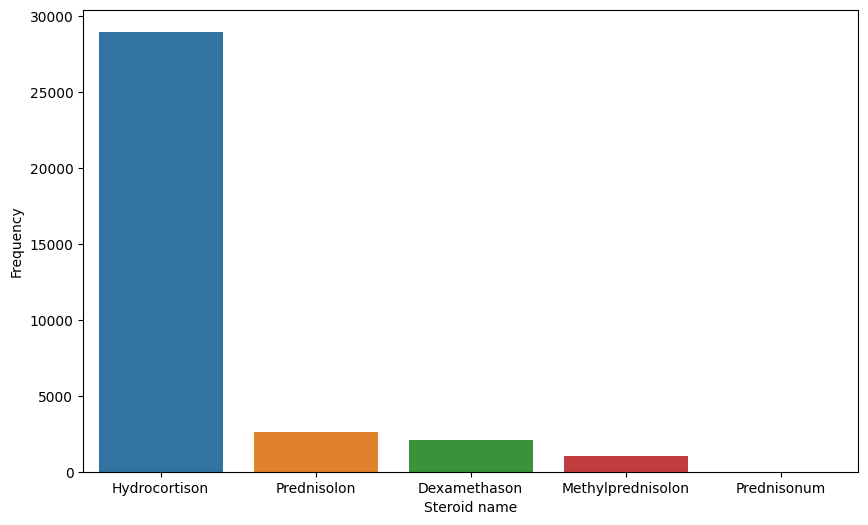

In [ ]:
# Count the frequency of each itemid
item_freq = steroids['steroid_name'].value_counts()

# Plot the frequency
plt.figure(figsize=(10, 6))
sns.countplot(x=steroids['steroid_name'], order=item_freq.index)
# plt.title('Frequency Plot for different steroids')
plt.xlabel('Steroid name')
plt.ylabel('Frequency')
plt.show()

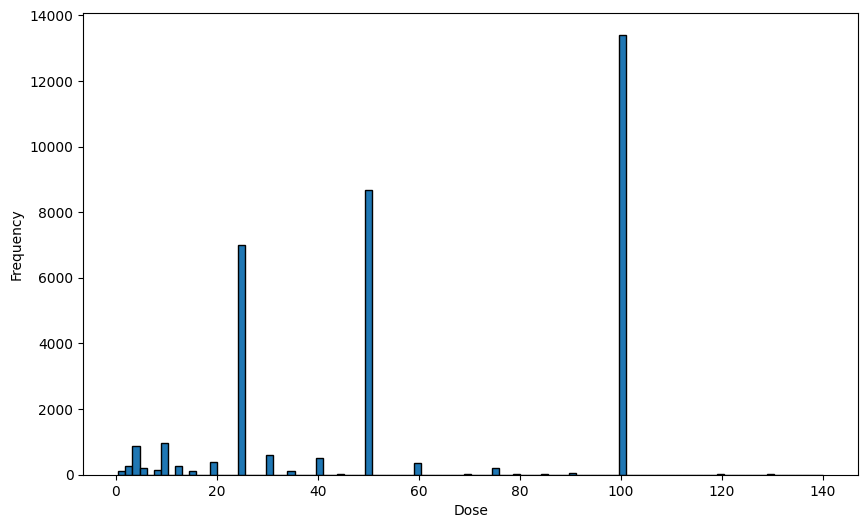

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(steroids[steroids['dose'] < 150]['dose'], bins=100, edgecolor='black')  # Adjust the number of bins as needed
# plt.title('Histogram of Dose')
plt.xlabel('Dose')
plt.ylabel('Frequency')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

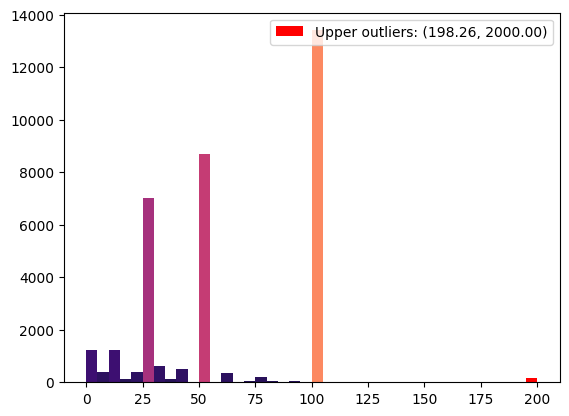

In [ ]:
adb.outliers_histogram(steroids['dose'], z_threshold=4.0, lower=None, upper=None, bins=None, binwidth=None, maxbins=None)

Remove outliers

In [ ]:
steroids.shape

(34699, 14)

In [ ]:
steroids = steroids[steroids['dose'] <= 250]
steroids.shape

(34540, 14)

In [ ]:
len(set(sepsis_cohort.admissionid).intersection(set(steroids.admissionid)))

1798

In [ ]:
steroids['action'].unique() # 'New administration'

array(['Nieuwe toediening'], dtype=object)

In [ ]:
steroids['duration'].unique()

<IntegerArray>
[1]
Length: 1, dtype: Int64

In [ ]:
steroids['doseunit'].unique()

array(['mg'], dtype=object)

- All the actions we have are the new admnisrations from doctor.
- All the doses are in 'mg' unit.
- All the durations are equal 1 minute.

In [ ]:
print('Doseunit:', steroids['doseunit'].unique())
print('Dose:', steroids['dose'].unique())
print('Number of different doses:', steroids['dose'].nunique())


# print('Rateunit:', steroids['rateunit'].unique())
# print('Rate:', steroids['rate'].unique())

# print('Administeredunit:', steroids['administered'].unique())
# print('Administered:', steroids['administeredunit'].unique())

Doseunit: ['mg']
Dose: [  3.    0.5   7.5 120.   45.    2.5   1.   35.   15.    8.  130.   85.
 160.    6.   70.   90.   55.   80.   24.  140.  200.  101.   51.  170.
  17.5   2.    4.    5.   10.   12.5  20.   25.   30.   40.   50.   60.
 100.   75. ]
Number of different doses: 38


In [ ]:
steroids['dose'].describe()

count    34540.000000
mean        60.308208
std         34.578062
min          0.500000
25%         25.000000
50%         50.000000
75%        100.000000
max        200.000000
Name: dose, dtype: float64

In [ ]:
steroids.describe()

,admissionid,itemid,dose,administered,start,stop,duration,fluidin,time
count,34540.0,34540.0,34540.000000,34540.000000,34540.0,34540.0,34540.0,34540.000000,34540.000000
mean,11929.940012,7111.240706,60.308208,60.308208,4044668121.019108,4044728121.019108,1.0,9.959690,14871.384684
std,6784.714997,174.032279,34.578062,34.578062,21101922969.598007,21101922969.598007,0.0,21.079534,17756.406411
min,11.0,6922.0,0.500000,0.500000,0.0,60000.0,1.0,0.000000,0.000000
25%,6122.0,7106.0,25.000000,25.000000,259980000.0,260040000.0,1.0,0.000000,3740.750000
50%,12481.0,7106.0,50.000000,50.000000,629310000.0,629370000.0,1.0,0.000000,8908.000000
75%,17638.0,7106.0,100.000000,100.000000,1443015000.0,1443075000.0,1.0,5.000000,18604.250000
max,23540.0,9130.0,200.000000,200.000000,317243100000.0,317243160000.0,1.0,501.000000,143890.000000


In [ ]:
steroids.columns

Index(['admissionid', 'itemid', 'dose', 'doseunit', 'doserateunit',
       'administered', 'administeredunit', 'action', 'start', 'stop',
       'duration', 'fluidin', 'time', 'steroid_name'],
      dtype='object')

In [ ]:
columns_of_interest = ['admissionid', 'steroid_name', 'dose', 'time']

In [ ]:
steroids = steroids[columns_of_interest].copy()

In [ ]:
steroids.shape

(34540, 4)

In [ ]:
steroids.head()

,admissionid,steroid_name,dose,time
7,13270,Dexamethason,3.0,766.0
15,13270,Dexamethason,3.0,2926.0
24,10358,Dexamethason,0.5,3913.0
32,5011,Prednisolon,7.5,42580.0
38,5011,Prednisolon,7.5,11500.0


In [ ]:
steroids['admissionid'].nunique()

1798

Checking if person gets different steroids during admission.

In [ ]:
diff_steroids_per_admission = steroids[['admissionid', 'steroid_name']].groupby(['admissionid'])['steroid_name'].agg(unique_values=pd.Series.unique).reset_index()

In [ ]:
mask = [len(u) > 1 for u in diff_steroids_per_admission['unique_values']]
diff_steroids_per_admission[mask]

,admissionid,unique_values
6,91,"[Dexamethason, Hydrocortison]"
25,299,"[Prednisolon, Hydrocortison]"
27,318,"[Methylprednisolon, Hydrocortison]"
58,814,"[Prednisolon, Hydrocortison]"
63,880,"[Prednisolon, Hydrocortison]"
...,...,...
1759,22898,"[Prednisolon, Hydrocortison]"
1763,22924,"[Prednisolon, Hydrocortison]"
1785,23395,"[Prednisolon, Hydrocortison]"
1790,23470,"[Hydrocortison, Prednisolon]"


In [ ]:
len(diff_steroids_per_admission[mask])

200

In [ ]:
 steroids[steroids['admissionid'] == 896].sort_values('time')

,admissionid,steroid_name,dose,time
70536,896,Hydrocortison,100.0,260.0
59891,896,Hydrocortison,100.0,740.0
75319,896,Hydrocortison,100.0,1220.0
57051,896,Hydrocortison,100.0,1700.0
64270,896,Hydrocortison,100.0,2180.0
81976,896,Prednisonum,75.0,2660.0
82269,896,Prednisolon,75.0,3500.0
81989,896,Prednisolon,75.0,4220.0
81996,896,Prednisolon,75.0,4940.0
81995,896,Prednisolon,75.0,5660.0


In [ ]:
steroids[steroids['admissionid'] == 976].sort_values('time')

,admissionid,steroid_name,dose,time
61665,976,Hydrocortison,100.0,104.0
77089,976,Hydrocortison,100.0,584.0
69949,976,Hydrocortison,100.0,1064.0
70341,976,Hydrocortison,100.0,1544.0
59893,976,Hydrocortison,100.0,2024.0
...,...,...,...,...
1010,976,Prednisolon,15.0,73304.0
2309,976,Prednisolon,15.0,74744.0
9785,976,Prednisolon,10.0,76184.0
10469,976,Prednisolon,10.0,77624.0


In [ ]:
sum([len(u) > 1 for u in diff_steroids_per_admission['unique_values']])

200

In [ ]:
for name in steroids['steroid_name'].unique():
  print(f'{name} - dosages: {sorted(steroids[steroids["steroid_name"] == name]["dose"].unique())}')

Dexamethason - dosages: [0.5, 1.0, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.5, 8.0, 10.0, 20.0, 24.0, 40.0, 50.0, 80.0, 100.0]
Prednisolon - dosages: [2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 70.0, 75.0, 80.0, 85.0, 90.0, 100.0, 120.0, 130.0, 200.0]
Methylprednisolon - dosages: [2.0, 4.0, 5.0, 8.0, 10.0, 15.0, 17.5, 20.0, 25.0, 30.0, 35.0, 40.0, 50.0, 60.0, 85.0, 90.0, 120.0, 140.0, 160.0, 170.0]
Hydrocortison - dosages: [10.0, 12.5, 15.0, 20.0, 24.0, 25.0, 50.0, 51.0, 75.0, 100.0, 101.0, 200.0]
Prednisonum - dosages: [5.0, 10.0, 30.0, 75.0]


In [ ]:
steroids = steroids.sort_values(['admissionid', 'steroid_name', 'time'])

In [ ]:
steroids.head(15)

,admissionid,steroid_name,dose,time
78982,11,Hydrocortison,100.0,304.0
61635,11,Hydrocortison,100.0,784.0
53391,11,Hydrocortison,100.0,1264.0
54508,11,Hydrocortison,100.0,1744.0
4780,20,Dexamethason,4.0,40.0
5224,20,Dexamethason,4.0,1480.0
6681,20,Dexamethason,4.0,2920.0
7332,20,Dexamethason,4.0,4360.0
4879,20,Dexamethason,4.0,5800.0
3562,20,Dexamethason,4.0,7240.0


## Merge measurements and steroids

In [ ]:
measurements_wide.head()

itemid,admissionid,time,6640,6641,6642,6643,6709,6778,6779,6797,...,9964,9965,10053,10284,10285,10286,10409,13060,14216,14252
577,11,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578,11,64.0,150.0,80.0,58.0,46.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579,11,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.0,8.9,5.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
580,11,81.0,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581,11,84.0,143.0,89.0,67.0,53.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,133.0,4.0,5.8,NaN,NaN,NaN,NaN


In [ ]:
measurements_wide.shape

(798074, 38)

In [ ]:
steroids.shape

(34540, 4)

In [ ]:
meas_ster_data = measurements_wide.join(steroids.set_index(['admissionid', 'time'], drop=True),
                                        on=['admissionid', 'time'], how='outer')
meas_ster_data.shape

(801087, 40)

In [ ]:
meas_ster_data.head()

,admissionid,time,6640,6641,6642,6643,6709,6778,6779,6797,...,10053,10284,10285,10286,10409,13060,14216,14252,steroid_name,dose
577,11,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578,11,64.0,150.0,80.0,58.0,46.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
579,11,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
580,11,81.0,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
581,11,84.0,143.0,89.0,67.0,53.0,NaN,NaN,NaN,NaN,...,NaN,133.0,4.0,5.8,NaN,NaN,NaN,NaN,NaN,NaN


Compose one column from several columns with one lab result.

In [ ]:
features_grouped

,vocabulary_concept_code,itemid
0,15045-8,"[6836, 9941, 14216]"
1,15074-8,"[6833, 9557, 9947]"
2,26464-8,"[6779, 9965]"
3,26515-7,"[6797, 9964, 10409, 14252]"
4,2823-3,"[6835, 9927]"
5,2947-0,"[9555, 10284]"
6,2951-2,"[6840, 9924]"
7,32693-4,"[6837, 9580, 10053]"
8,54363-7,"[6813, 9945]"
9,59260-0,"[6778, 9553, 9960, 10286]"


In [ ]:
meas_ster_data = meas_ster_data.sort_values(['admissionid', 'time']).reset_index(drop=True)

In [ ]:
meas_ster_data.columns

Index([ 'admissionid',         'time',           6640,           6641,
                 6642,           6643,           6709,           6778,
                 6779,           6797,           6813,           6833,
                 6835,           6836,           6837,           6840,
                 8874,           9553,           9555,           9556,
                 9557,           9580,           9924,           9927,
                 9941,           9945,           9947,           9960,
                 9964,           9965,          10053,          10284,
                10285,          10286,          10409,          13060,
                14216,          14252, 'steroid_name',         'dose'],
      dtype='object')

In [ ]:
# change order of columns
meas_ster_data = meas_ster_data[['admissionid', 'time'] + list(meas_ster_data.columns[-2:]) + list(meas_ster_data.columns[2:-2])]

In [ ]:
meas_ster_data.columns

Index([ 'admissionid',         'time', 'steroid_name',         'dose',
                 6640,           6641,           6642,           6643,
                 6709,           6778,           6779,           6797,
                 6813,           6833,           6835,           6836,
                 6837,           6840,           8874,           9553,
                 9555,           9556,           9557,           9580,
                 9924,           9927,           9941,           9945,
                 9947,           9960,           9964,           9965,
                10053,          10284,          10285,          10286,
                10409,          13060,          14216,          14252],
      dtype='object')

In [ ]:
# Group columns in meas_ster_data based on grouping in features_grouped
for columns in features_grouped['itemid']:
    # Combine columns in meas_ster_data for the current group - taking mean
    meas_ster_data[f'{columns[0]}_comb'] = meas_ster_data[columns].mean(axis=1)
    # print(np.any((~meas_ster_data[columns].isna()).sum(axis=1) > 1))
    # print(meas_ster_data[columns][(~meas_ster_data[columns].isna()).sum(axis=1) > 1])

    # Drop the original columns in meas_ster_data that were combined
    meas_ster_data.drop(columns=columns, inplace=True)


In [ ]:
meas_ster_data.head()

,admissionid,time,steroid_name,dose,6640,6641,6642,6643,6709,8874,...,6833_comb,6779_comb,6797_comb,6835_comb,9555_comb,6840_comb,6837_comb,6813_comb,6778_comb,9556_comb
0,11,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,64.0,NaN,NaN,150.0,80.0,58.0,46.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.3,8.9,127.0,3.9,NaN,136.0,5.9,17.0,6.0,NaN
3,11,81.0,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,84.0,NaN,NaN,143.0,89.0,67.0,53.0,NaN,NaN,...,6.5,NaN,NaN,NaN,133.0,NaN,NaN,NaN,5.8,4.0


In [ ]:
updated_cols = ['admissionid', 'time', 'steroid_name', 'dose']
for c in meas_ster_data.columns[4:]:
  names = str(c).split('_')
  if len(names) < 3:
    updated_cols.append(itemid_to_name[int(names[0])])
  else:
    updated_cols.append(names[-1])

In [ ]:
meas_ster_data.columns = updated_cols

In [ ]:
meas_ster_data.head(15)

,admissionid,time,steroid_name,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,...,glucose_bloed,leucocyten,thrombocyten,kalium,natrium_astrup,natrium,laktaat,bili_totaal,hemoglobine,kalium_astrup
0,11,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,64.0,NaN,NaN,150.0,80.0,58.0,46.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.3,8.9,127.0,3.9,NaN,136.0,5.9,17.0,6.0,NaN
3,11,81.0,NaN,NaN,NaN,NaN,NaN,NaN,59.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,84.0,NaN,NaN,143.0,89.0,67.0,53.0,NaN,NaN,...,6.5,NaN,NaN,NaN,133.0,NaN,NaN,NaN,5.8,4.0
5,11,90.0,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,11,124.0,NaN,NaN,147.0,92.0,66.0,52.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,11,184.0,NaN,NaN,145.0,89.0,62.0,49.0,NaN,NaN,...,6.3,NaN,NaN,NaN,134.0,NaN,NaN,NaN,6.0,4.4
8,11,244.0,NaN,NaN,141.0,86.0,64.0,51.0,NaN,NaN,...,5.8,NaN,NaN,NaN,134.0,NaN,NaN,NaN,6.0,4.6
9,11,304.0,Hydrocortison,100.0,133.0,91.0,72.0,58.0,97.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We should shift every admission to a starting point of steroid, not admission time.

Let's find the first occurance of steroids and will get it as beginning for our time.

In [ ]:
meas_ster_data['first_dose_occurrence'] = meas_ster_data.groupby('admissionid')['dose'].transform(lambda x: x.first_valid_index())

<ipython-input-103-be23d613cd9b>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  meas_ster_data['first_dose_occurrence'] = meas_ster_data.groupby('admissionid')['dose'].transform(lambda x: x.first_valid_index())


Get admissions for which we do not have information for steroids.

In [ ]:
meas_ster_data.admissionid.nunique(), meas_ster_data.shape

(3019, (801087, 23))

In [ ]:
meas_ster_data['first_dose_occurrence']

0              9.0
1              9.0
2              9.0
3              9.0
4              9.0
            ...   
801082    800996.0
801083    800996.0
801084    800996.0
801085    800996.0
801086    800996.0
Name: first_dose_occurrence, Length: 801087, dtype: float64

In [ ]:
meas_ster_data[meas_ster_data.index >= meas_ster_data['first_dose_occurrence']][meas_ster_data.admissionid == 11]

<ipython-input-106-bdfdcd2b875a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  meas_ster_data[meas_ster_data.index >= meas_ster_data['first_dose_occurrence']][meas_ster_data.admissionid == 11]


,admissionid,time,steroid_name,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,...,leucocyten,thrombocyten,kalium,natrium_astrup,natrium,laktaat,bili_totaal,hemoglobine,kalium_astrup,first_dose_occurrence
9,11,304.0,Hydrocortison,100.0,133.0,91.0,72.0,58.0,97.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
10,11,312.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.1,NaN,NaN,NaN,9.0
11,11,364.0,NaN,NaN,141.0,103.0,81.0,68.0,87.0,NaN,...,NaN,NaN,NaN,135.0,NaN,NaN,NaN,6.5,4.7,9.0
12,11,394.0,NaN,NaN,135.0,89.0,70.0,57.0,96.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
13,11,424.0,NaN,NaN,131.0,NaN,NaN,NaN,98.0,NaN,...,NaN,NaN,NaN,135.0,NaN,NaN,NaN,6.4,4.5,9.0
14,11,425.0,NaN,NaN,NaN,95.0,NaN,61.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
15,11,484.0,NaN,NaN,126.0,96.0,75.0,61.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
16,11,490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,132.0,4.6,NaN,140.0,NaN,NaN,6.0,NaN,9.0
17,11,544.0,NaN,NaN,127.0,95.0,71.0,58.0,NaN,NaN,...,NaN,NaN,NaN,135.0,NaN,NaN,NaN,6.7,4.6,9.0
18,11,604.0,NaN,NaN,126.0,96.0,69.0,57.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0


Remove the entries which do not have steroids data.

In [ ]:
meas_ster_data.shape

(801087, 23)

In [ ]:
meas_ster_data = meas_ster_data.dropna(subset=['first_dose_occurrence', ])
meas_ster_data.shape

(633206, 23)

### Centering data to steroids start

Removing all the timestamps before first occurance of steroids.

In [ ]:
meas_ster_data[meas_ster_data.admissionid == 23540][:10]

,admissionid,time,steroid_name,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,...,leucocyten,thrombocyten,kalium,natrium_astrup,natrium,laktaat,bili_totaal,hemoglobine,kalium_astrup,first_dose_occurrence
800991,23540,26.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800996.0
800992,23540,37.0,NaN,NaN,88.0,125.0,88.0,67.0,96.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800996.0
800993,23540,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,140.0,NaN,NaN,NaN,7.5,2.9,800996.0
800994,23540,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,139.0,NaN,NaN,NaN,8.0,3.2,800996.0
800995,23540,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.2,136.0,3.3,NaN,142.0,4.3,19.0,8.1,NaN,800996.0
800996,23540,97.0,Hydrocortison,100.0,90.0,102.0,73.0,57.0,97.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800996.0
800997,23540,157.0,NaN,NaN,84.0,104.0,75.0,59.0,97.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800996.0
800998,23540,185.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,138.0,NaN,NaN,NaN,8.4,3.7,800996.0
800999,23540,193.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,800996.0
801000,23540,217.0,NaN,NaN,79.0,109.0,80.0,64.0,97.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800996.0


Removing all data before starting steroids

In [ ]:
mask = meas_ster_data.index < meas_ster_data['first_dose_occurrence']
mask[:15]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False])

In [ ]:
# Drop rows based on the boolean mask
meas_ster_data = meas_ster_data[~mask]
meas_ster_data.shape

(569817, 23)

In [ ]:
meas_ster_data = meas_ster_data.drop('first_dose_occurrence', axis=1)
meas_ster_data.shape

(569817, 22)

Now we will center all the observations to the beginning of steroids

In [ ]:
meas_ster_data['time'] = meas_ster_data.groupby('admissionid')['time'].transform(lambda x: x - x.iloc[0])
meas_ster_data.head(10)

,admissionid,time,steroid_name,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,...,glucose_bloed,leucocyten,thrombocyten,kalium,natrium_astrup,natrium,laktaat,bili_totaal,hemoglobine,kalium_astrup
9,11,0.0,Hydrocortison,100.0,133.0,91.0,72.0,58.0,97.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,11,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.1,NaN,NaN,NaN
11,11,60.0,NaN,NaN,141.0,103.0,81.0,68.0,87.0,NaN,...,5.9,NaN,NaN,NaN,135.0,NaN,NaN,NaN,6.5,4.7
12,11,90.0,NaN,NaN,135.0,89.0,70.0,57.0,96.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,11,120.0,NaN,NaN,131.0,NaN,NaN,NaN,98.0,NaN,...,5.9,NaN,NaN,NaN,135.0,NaN,NaN,NaN,6.4,4.5
14,11,121.0,NaN,NaN,NaN,95.0,NaN,61.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,11,180.0,NaN,NaN,126.0,96.0,75.0,61.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,11,186.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.6,5.0,132.0,4.6,NaN,140.0,NaN,NaN,6.0,NaN
17,11,240.0,NaN,NaN,127.0,95.0,71.0,58.0,NaN,NaN,...,5.8,NaN,NaN,NaN,135.0,NaN,NaN,NaN,6.7,4.6
18,11,300.0,NaN,NaN,126.0,96.0,69.0,57.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Binning time, aggregate observations into 4 hours window and get mean



In [ ]:
meas_ster_data[meas_ster_data.admissionid == 47]

,admissionid,time,steroid_name,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,...,glucose_bloed,leucocyten,thrombocyten,kalium,natrium_astrup,natrium,laktaat,bili_totaal,hemoglobine,kalium_astrup
358,47,0.0,Hydrocortison,100.0,127.0,121.0,89.0,71.0,91.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,47,60.0,NaN,NaN,125.0,94.0,73.0,61.0,90.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360,47,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.5,NaN,NaN,NaN,138.0,NaN,3.6,NaN,6.9,4.7
361,47,120.0,NaN,NaN,126.0,90.0,75.0,63.0,88.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,47,180.0,NaN,NaN,114.0,116.0,90.0,74.0,90.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,47,6180.0,NaN,NaN,78.0,147.0,81.0,57.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,47,6232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.4,NaN,NaN,NaN,137.0,NaN,1.5,NaN,5.1,3.5
478,47,6240.0,NaN,NaN,73.0,146.0,78.0,54.0,92.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,47,6300.0,NaN,NaN,72.0,145.0,75.0,50.0,91.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
meas_ster_data['steroid_name'] = meas_ster_data.groupby('admissionid')['steroid_name'].ffill()

In [ ]:
meas_ster_data['time_bin'] = meas_ster_data['time'] // 240
meas_ster_data = meas_ster_data.drop(['time'], axis=1)

In [ ]:
meas_ster_data = meas_ster_data.groupby(['admissionid', 'steroid_name', 'time_bin']).mean().reset_index()
# meas_ster_data['dose'] = meas_ster_data.groupby('admissionid')['dose'].ffill()

In [ ]:
meas_ster_data.head(10)

,admissionid,steroid_name,time_bin,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,...,glucose_bloed,leucocyten,thrombocyten,kalium,natrium_astrup,natrium,laktaat,bili_totaal,hemoglobine,kalium_astrup
0,11,Hydrocortison,0.0,100.0,133.20,94.800000,74.500000,61.000000,94.50,NaN,...,5.800000,5.0,132.0,4.6,135.000000,140.0,6.1,NaN,6.300000,4.600000
1,11,Hydrocortison,1.0,NaN,123.25,96.500000,69.750000,57.000000,96.00,NaN,...,5.100000,NaN,NaN,NaN,134.333333,NaN,NaN,NaN,6.633333,4.600000
2,11,Hydrocortison,2.0,100.0,126.00,96.000000,67.000000,54.000000,95.00,NaN,...,6.600000,NaN,NaN,NaN,132.666667,NaN,4.9,NaN,6.733333,4.666667
3,11,Hydrocortison,3.0,NaN,121.00,105.250000,62.250000,48.250000,97.25,NaN,...,6.300000,NaN,98.0,4.8,134.333333,141.0,4.7,27.0,6.625000,4.533333
4,11,Hydrocortison,4.0,100.0,129.20,108.200000,63.600000,48.200000,98.75,NaN,...,4.650000,NaN,NaN,NaN,134.500000,NaN,NaN,NaN,7.200000,4.600000
5,11,Hydrocortison,5.0,NaN,129.25,74.000000,59.250000,49.750000,96.75,NaN,...,5.100000,NaN,NaN,NaN,134.000000,NaN,NaN,NaN,5.966667,4.466667
6,11,Hydrocortison,6.0,100.0,129.00,94.333333,77.333333,64.333333,96.25,NaN,...,5.425000,10.4,30.0,4.5,134.333333,144.0,7.2,NaN,5.700000,4.333333
7,11,Hydrocortison,7.0,NaN,119.50,90.666667,64.333333,47.000000,100.00,NaN,...,4.366667,NaN,NaN,NaN,135.333333,NaN,NaN,NaN,5.433333,4.766667
8,20,Dexamethason,0.0,4.0,90.75,74.400000,52.000000,41.200000,95.60,41.25,...,24.400001,NaN,NaN,NaN,129.500000,NaN,6.5,NaN,9.050000,3.300000
9,20,Dexamethason,1.0,NaN,87.00,104.750000,71.000000,52.750000,99.00,29.50,...,11.566667,9.1,121.0,NaN,131.000000,NaN,4.2,10.0,7.933333,3.550000


In [ ]:
dose_values = meas_ster_data['dose'].unique()

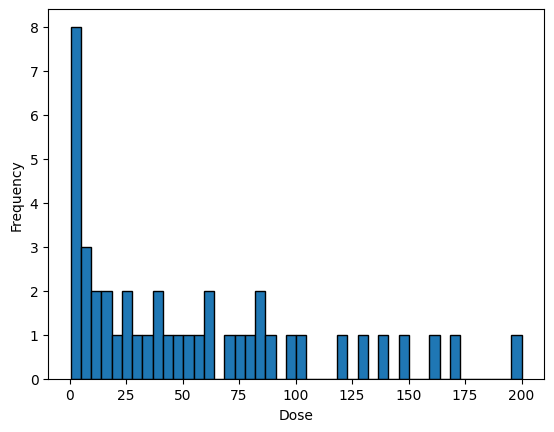

In [ ]:
# Plotting the histogram
plt.hist(dose_values, bins=len(dose_values), edgecolor='black')
plt.xlabel('Dose')
plt.ylabel('Frequency')
# plt.title('Histogram of Unique Dose Values after Binning')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

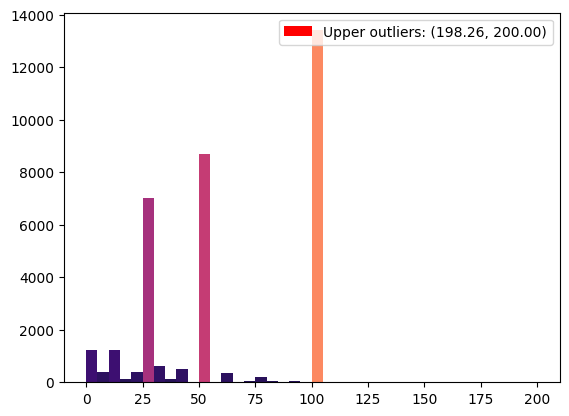

In [ ]:
adb.outliers_histogram(steroids['dose'], z_threshold=4.0, lower=None, upper=None, bins=None, binwidth=None, maxbins=None)

Fill NA for steroids 'dose' with forward filling.

In [ ]:
meas_ster_data['dose'] = meas_ster_data['dose'].ffill()

In [ ]:
for name in meas_ster_data['steroid_name'].unique():
  print(f'{name} - dosages: {sorted(meas_ster_data[meas_ster_data["steroid_name"] == name]["dose"].unique())}')

Hydrocortison - dosages: [10.0, 12.5, 15.0, 20.0, 24.0, 25.0, 37.5, 50.0, 51.0, 62.5, 75.0, 83.33333333333333, 100.0, 101.0, 150.0, 200.0]
Dexamethason - dosages: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.5, 8.0, 10.0, 20.0, 24.0, 40.0, 50.0, 80.0, 100.0]
Prednisolon - dosages: [2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 70.0, 75.0, 80.0, 85.0, 90.0, 100.0, 120.0, 130.0, 200.0]
Methylprednisolon - dosages: [2.0, 4.0, 5.0, 8.0, 10.0, 15.0, 17.5, 20.0, 25.0, 30.0, 35.0, 40.0, 50.0, 60.0, 85.0, 90.0, 120.0, 140.0, 160.0, 170.0]
Prednisonum - dosages: [5.0, 10.0, 30.0, 75.0]


# Merge temporal and static features

In [ ]:
sepsis_cohort.head()

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,...,other_antibiotics_given,sepsis_cultures_bool,sepsis_cultures_drawn,sofa_respiration_score,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score
0,11,11,1,IC,1,None,0,2003-2009,148620000,42,...,None,1,Legionella sneltest (urine),2.0,2.0,1.0,4.0,NaN,4.0,13.0
1,19,20,1,IC,1,None,0,2003-2009,605100000,168,...,Amoxicilline/Clavulaanzuur (Augmentin),1,Bloedkweken afnemen,2.0,1.0,0.0,1.0,NaN,1.0,5.0
2,24,25,1,MC,0,None,0,2003-2009,247020000,69,...,None,<NA>,None,2.0,2.0,4.0,3.0,NaN,2.0,13.0
3,41,44,1,IC,0,None,0,2003-2009,77220000,21,...,Vancomycine,<NA>,None,2.0,4.0,2.0,1.0,NaN,0.0,9.0
4,43,47,2,IC,1,Verpleegafdeling zelfde ziekenhuis,166080000,2010-2016,562560000,110,...,None,<NA>,None,2.0,1.0,0.0,4.0,0.0,3.0,10.0


In [ ]:
sepsis_cohort.columns

Index(['patientid', 'admissionid', 'admissioncount', 'location', 'urgency',
       'origin', 'admittedat', 'admissionyeargroup', 'dischargedat',
       'lengthofstay', 'destination', 'gender', 'agegroup', 'dateofdeath',
       'weightgroup', 'weightsource', 'heightgroup', 'heightsource',
       'specialty', 'diagnosis_type', 'diagnosis', 'diagnosis_id',
       'diagnosis_subgroup', 'diagnosis_subgroup_id', 'diagnosis_group',
       'diagnosis_group_id', 'surgical', 'sepsis_at_admission',
       'sepsis_antibiotics_bool', 'sepsis_antibiotics_given',
       'other_antibiotics_bool', 'other_antibiotics_given',
       'sepsis_cultures_bool', 'sepsis_cultures_drawn',
       'sofa_respiration_score', 'sofa_coagulation_score', 'sofa_liver_score',
       'sofa_cardiovascular_score', 'sofa_cns_score', 'sofa_renal_score',
       'sofa_total_score'],
      dtype='object')

## Process outcomes

In [ ]:
sepsis_cohort['dateofdeath_centered'] = center_time(sepsis_cohort, 'dateofdeath')
sepsis_cohort['dayofdeath'] = convert_miliseconds_to_days(sepsis_cohort, 'dateofdeath_centered')

sepsis_cohort['dayofdeath'] = sepsis_cohort['dayofdeath'].fillna(float('inf')) # people who are alive have 'inf' date


In [ ]:
sepsis_cohort['dead_30days'] = sepsis_cohort['dayofdeath'] < 30
sepsis_cohort['dead_90days'] = sepsis_cohort['dayofdeath'] < 90

In [ ]:
sepsis_cohort.head()

,patientid,admissionid,admissioncount,location,urgency,origin,admittedat,admissionyeargroup,dischargedat,lengthofstay,...,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score,dateofdeath_centered,dayofdeath,dead_30days,dead_90days
0,11,11,1,IC,1,None,0,2003-2009,148620000,42,...,2.0,1.0,4.0,NaN,4.0,13.0,133440000,1.544444,True,True
1,19,20,1,IC,1,None,0,2003-2009,605100000,168,...,1.0,0.0,1.0,NaN,1.0,5.0,<NA>,inf,False,False
2,24,25,1,MC,0,None,0,2003-2009,247020000,69,...,2.0,4.0,3.0,NaN,2.0,13.0,188700000,2.184028,True,True
3,41,44,1,IC,0,None,0,2003-2009,77220000,21,...,4.0,2.0,1.0,NaN,0.0,9.0,174729600000,2022.333333,False,False
4,43,47,2,IC,1,Verpleegafdeling zelfde ziekenhuis,166080000,2010-2016,562560000,110,...,1.0,0.0,4.0,0.0,3.0,10.0,32839020000,380.08125,False,False


## Merging

In [ ]:
static_columns = [
    'admissionid', 'gender', 'agegroup',
    'weightgroup', 'heightgroup', 'diagnosis_subgroup', 'sofa_respiration_score',
    'sofa_coagulation_score', 'sofa_liver_score', 'sofa_cardiovascular_score',
    'sofa_cns_score', 'sofa_renal_score', 'sofa_total_score',
    'dayofdeath', 'dead_30days',
    'dead_90days', 'lengthofstay',
  ]

cat_columns = [
    'gender', 'agegroup', 'weightgroup', 'heightgroup', 'diagnosis_subgroup',
  ]

In [ ]:
meas_ster_data.shape

(123667, 22)

In [ ]:
data = meas_ster_data.merge(sepsis_cohort[static_columns].set_index('admissionid', drop=True), on='admissionid', how='left')
data.shape

(123667, 38)

In [ ]:
data.columns

Index(['admissionid', 'steroid_name', 'time_bin', 'dose', 'heartrate',
       'sys_BP', 'mean_BP', 'dia_BP', 'saturation', 'resp_rate', 'temp_axil',
       'kreatinine', 'glucose_bloed', 'leucocyten', 'thrombocyten', 'kalium',
       'natrium_astrup', 'natrium', 'laktaat', 'bili_totaal', 'hemoglobine',
       'kalium_astrup', 'gender', 'agegroup', 'weightgroup', 'heightgroup',
       'diagnosis_subgroup', 'sofa_respiration_score',
       'sofa_coagulation_score', 'sofa_liver_score',
       'sofa_cardiovascular_score', 'sofa_cns_score', 'sofa_renal_score',
       'sofa_total_score', 'dayofdeath', 'dead_30days', 'dead_90days',
       'lengthofstay'],
      dtype='object')

In [ ]:
data.head()

,admissionid,steroid_name,time_bin,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,...,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score,dayofdeath,dead_30days,dead_90days,lengthofstay
0,11,Hydrocortison,0.0,100.0,133.20,94.80,74.50,61.00,94.50,NaN,...,2.0,1.0,4.0,NaN,4.0,13.0,1.544444,True,True,42
1,11,Hydrocortison,1.0,100.0,123.25,96.50,69.75,57.00,96.00,NaN,...,2.0,1.0,4.0,NaN,4.0,13.0,1.544444,True,True,42
2,11,Hydrocortison,2.0,100.0,126.00,96.00,67.00,54.00,95.00,NaN,...,2.0,1.0,4.0,NaN,4.0,13.0,1.544444,True,True,42
3,11,Hydrocortison,3.0,100.0,121.00,105.25,62.25,48.25,97.25,NaN,...,2.0,1.0,4.0,NaN,4.0,13.0,1.544444,True,True,42
4,11,Hydrocortison,4.0,100.0,129.20,108.20,63.60,48.20,98.75,NaN,...,2.0,1.0,4.0,NaN,4.0,13.0,1.544444,True,True,42


## Process NA

In [ ]:
sofa_columns = [
    'sofa_respiration_score', 'sofa_coagulation_score',
    'sofa_liver_score', 'sofa_cardiovascular_score',
    'sofa_cns_score', 'sofa_renal_score', 'sofa_total_score',
  ]

In [ ]:
data[sofa_columns] = data[sofa_columns].fillna(0)

In [ ]:
na_count = data.isna().sum() / len(data) * 100
na_count.sort_values()[na_count.sort_values() > 0]

heartrate              0.545821
saturation             1.723985
sys_BP                 4.040690
dia_BP                 4.043116
mean_BP                4.047968
weightgroup            4.561443
heightgroup            5.705645
glucose_bloed         20.690241
diagnosis_subgroup    34.661632
hemoglobine           35.813920
kalium_astrup         38.305288
natrium_astrup        40.681022
resp_rate             65.961008
temp_axil             72.342662
natrium               74.166916
kalium                74.890634
thrombocyten          77.327015
kreatinine            77.857472
leucocyten            78.316770
laktaat               83.958534
bili_totaal           92.713497
dtype: float64

In [ ]:
temp_columns = na_count.sort_values()[na_count.sort_values() > 0].index

In [ ]:
temp_columns

Index(['heartrate', 'saturation', 'sys_BP', 'dia_BP', 'mean_BP', 'weightgroup',
       'heightgroup', 'glucose_bloed', 'diagnosis_subgroup', 'hemoglobine',
       'kalium_astrup', 'natrium_astrup', 'resp_rate', 'temp_axil', 'natrium',
       'kalium', 'thrombocyten', 'kreatinine', 'leucocyten', 'laktaat',
       'bili_totaal'],
      dtype='object')

In [ ]:
data[temp_columns] = data.groupby('admissionid')[temp_columns].ffill()
# TODO: are we going to do backfill?
# data[temp_columns] = data.groupby('admissionid')[temp_columns].bfill()

In [ ]:
na_count = data.isna().sum() / len(data) * 100
na_count.sort_values()[na_count.sort_values() > 0]

heartrate              0.012129
saturation             0.050135
sys_BP                 0.104312
dia_BP                 0.104312
mean_BP                0.104312
glucose_bloed          0.266037
hemoglobine            0.703502
kalium_astrup          1.803230
kreatinine             2.562527
thrombocyten           2.626408
leucocyten             2.687863
natrium_astrup         3.719667
weightgroup            4.561443
natrium                4.586511
kalium                 4.979501
heightgroup            5.705645
bili_totaal           10.440134
laktaat               15.298342
resp_rate             25.613947
diagnosis_subgroup    34.661632
temp_axil             40.768354
dtype: float64

## Add column

In [ ]:
# Get the index of the last row in the original DataFrame
last_row_indices = data.groupby('admissionid').apply(lambda group: group.index[-1])
last_row_indices

admissionid
11            7
20           49
25           63
47           90
50          301
          ...  
23483    123570
23488    123602
23514    123606
23535    123649
23540    123666
Length: 1798, dtype: int64

In [ ]:
data['last_row'] = data.index.isin(last_row_indices)

In [ ]:
data.head()

,admissionid,steroid_name,time_bin,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,...,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score,dayofdeath,dead_30days,dead_90days,lengthofstay,last_row
0,11,Hydrocortison,0.0,100.0,133.20,94.80,74.50,61.00,94.50,NaN,...,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False
1,11,Hydrocortison,1.0,100.0,123.25,96.50,69.75,57.00,96.00,NaN,...,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False
2,11,Hydrocortison,2.0,100.0,126.00,96.00,67.00,54.00,95.00,NaN,...,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False
3,11,Hydrocortison,3.0,100.0,121.00,105.25,62.25,48.25,97.25,NaN,...,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False
4,11,Hydrocortison,4.0,100.0,129.20,108.20,63.60,48.20,98.75,NaN,...,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False


# Exploratory data analysis


In [ ]:
data.columns

Index(['admissionid', 'steroid_name', 'time_bin', 'dose', 'heartrate',
       'sys_BP', 'mean_BP', 'dia_BP', 'saturation', 'resp_rate', 'temp_axil',
       'kreatinine', 'glucose_bloed', 'leucocyten', 'thrombocyten', 'kalium',
       'natrium_astrup', 'natrium', 'laktaat', 'bili_totaal', 'hemoglobine',
       'kalium_astrup', 'gender', 'agegroup', 'weightgroup', 'heightgroup',
       'diagnosis_subgroup', 'sofa_respiration_score',
       'sofa_coagulation_score', 'sofa_liver_score',
       'sofa_cardiovascular_score', 'sofa_cns_score', 'sofa_renal_score',
       'sofa_total_score', 'dayofdeath', 'dead_30days', 'dead_90days',
       'lengthofstay', 'last_row'],
      dtype='object')

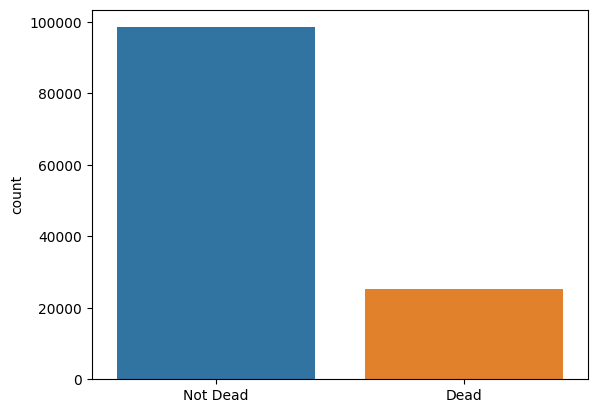

In [ ]:
sns.countplot(x='dead_30days', data=data)
# plt.title('Moratality rate for death within 30 days after admission starts')
plt.xlabel('')
plt.xticks([0, 1], ['Not Dead', 'Dead'])
plt.show()

In [ ]:
sum(data.groupby('admissionid').tail(1)['dead_30days']) / len(data.groupby('admissionid').tail(1)['dead_30days'])

0.3515016685205784

In [ ]:
numeric_columns = ['heartrate', 'sys_BP', 'mean_BP', 'dia_BP', 'saturation',
                   'resp_rate', 'temp_axil', 'kreatinine', 'glucose_bloed', 'leucocyten',
                   'thrombocyten', 'kalium', 'natrium_astrup', 'natrium', 'laktaat',
                   'bili_totaal', 'hemoglobine', 'kalium_astrup']


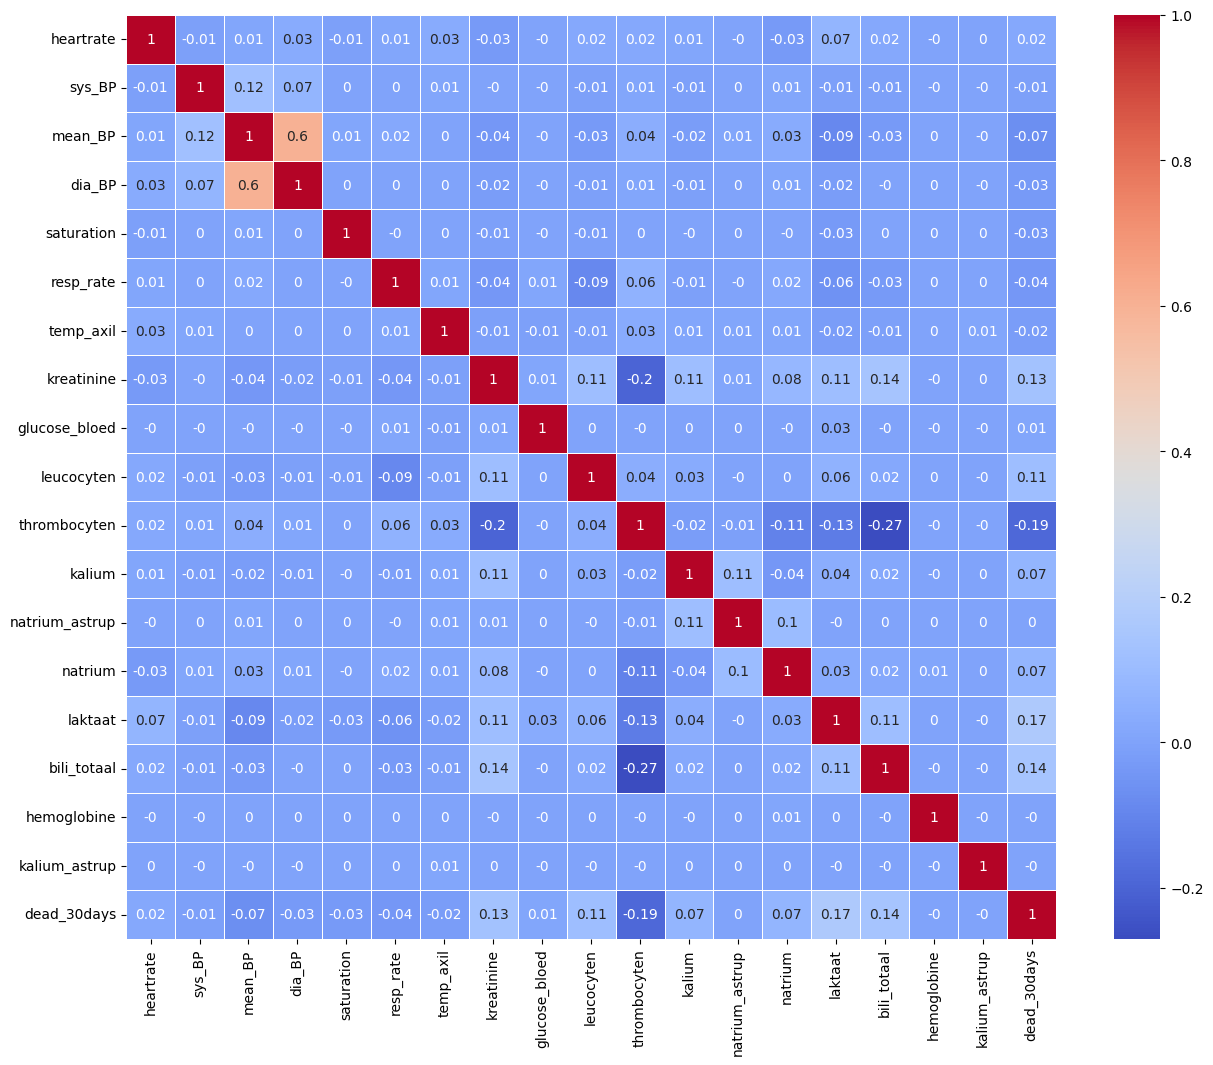

In [ ]:
correlation_matrix = data[numeric_columns + ['dead_30days']].corr().round(2)
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
# plt.title('Correlation Heatmap')
plt.show()

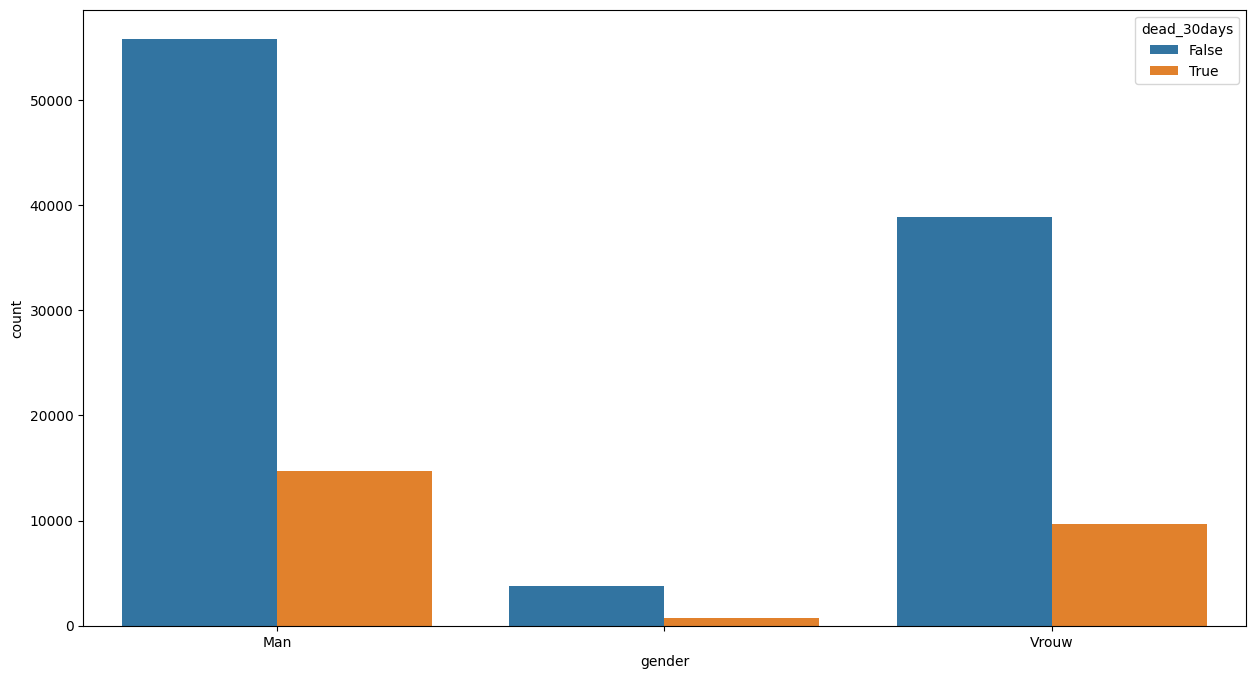

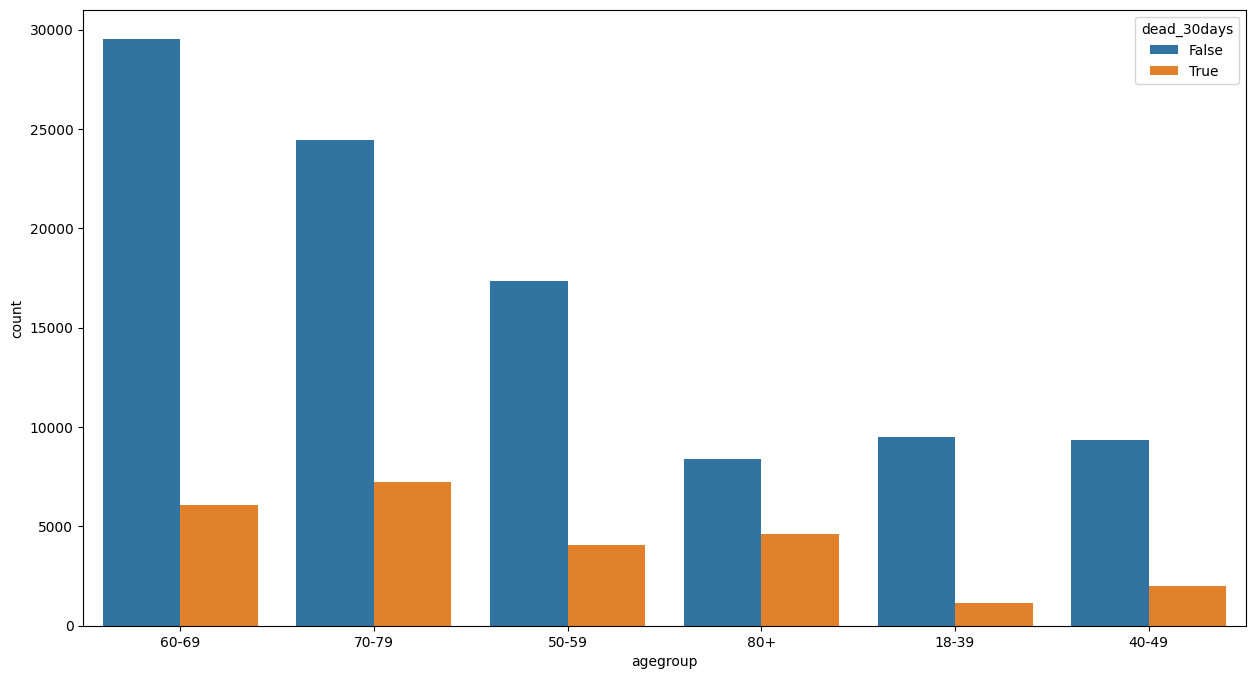

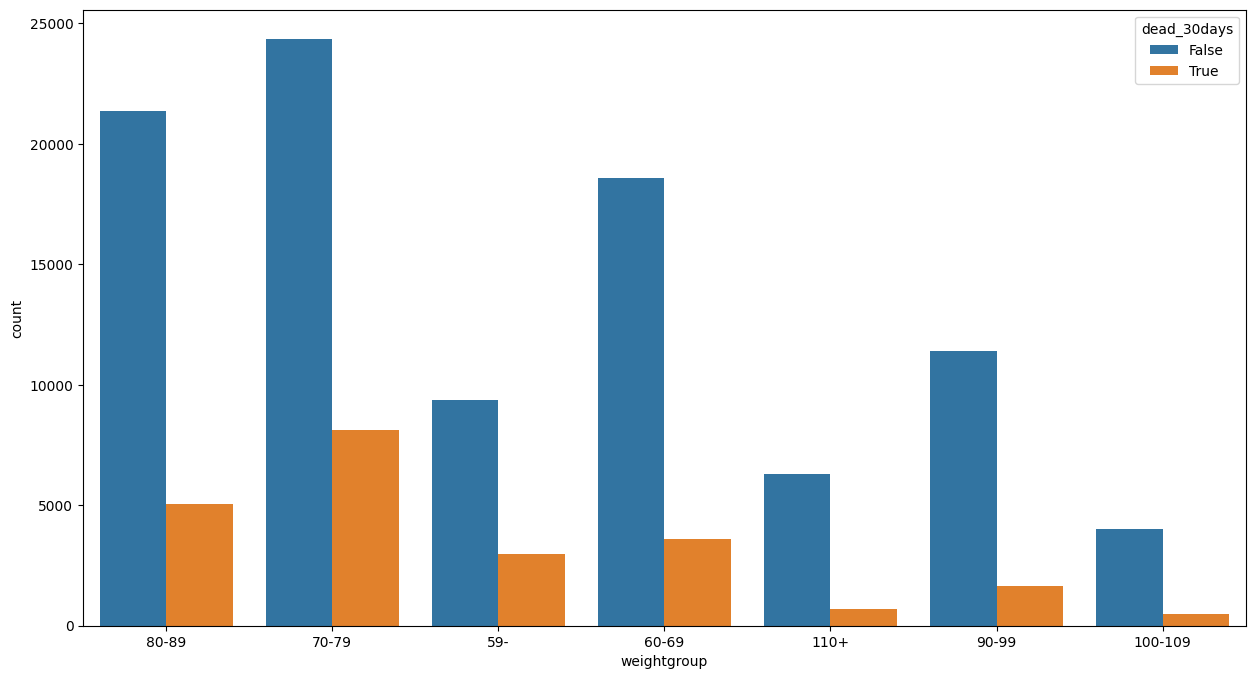

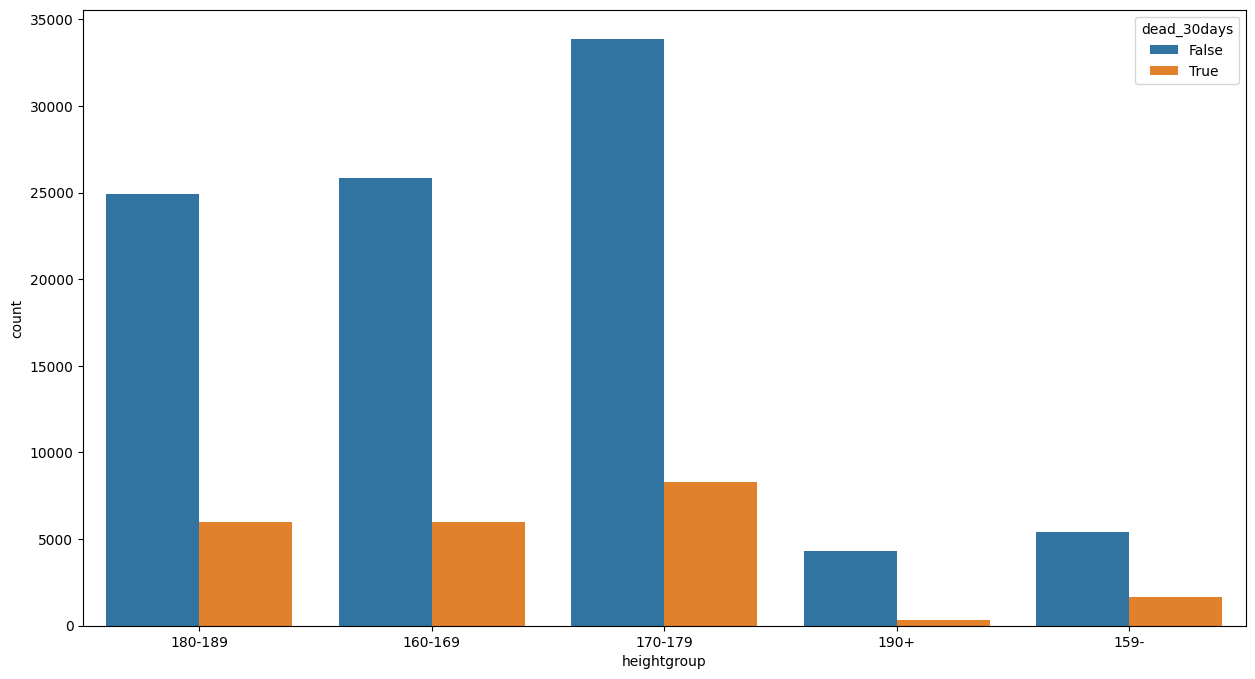

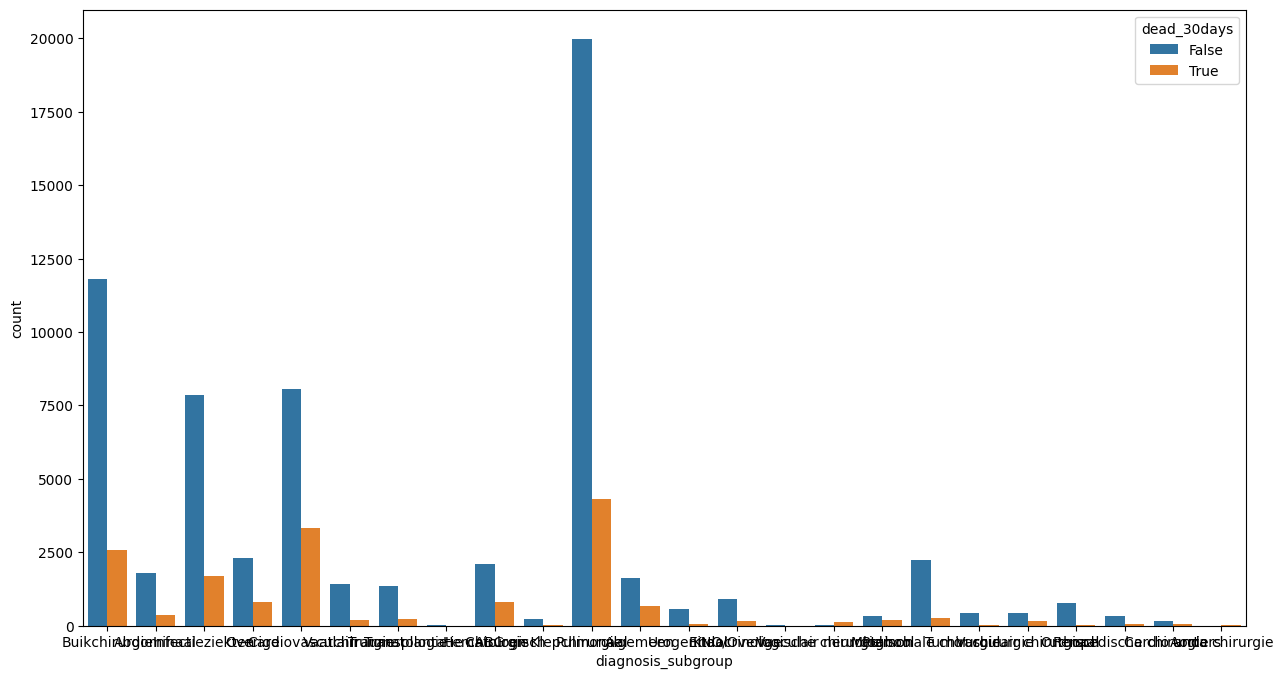

In [ ]:
categorical_columns = ['gender', 'agegroup', 'weightgroup', 'heightgroup', 'diagnosis_subgroup']

for column in categorical_columns:
    plt.figure(figsize=(15, 8))
    sns.countplot(x=column, hue='dead_30days', data=data)
    # plt.title(f'Mortality Rate by {column}')
    plt.show()

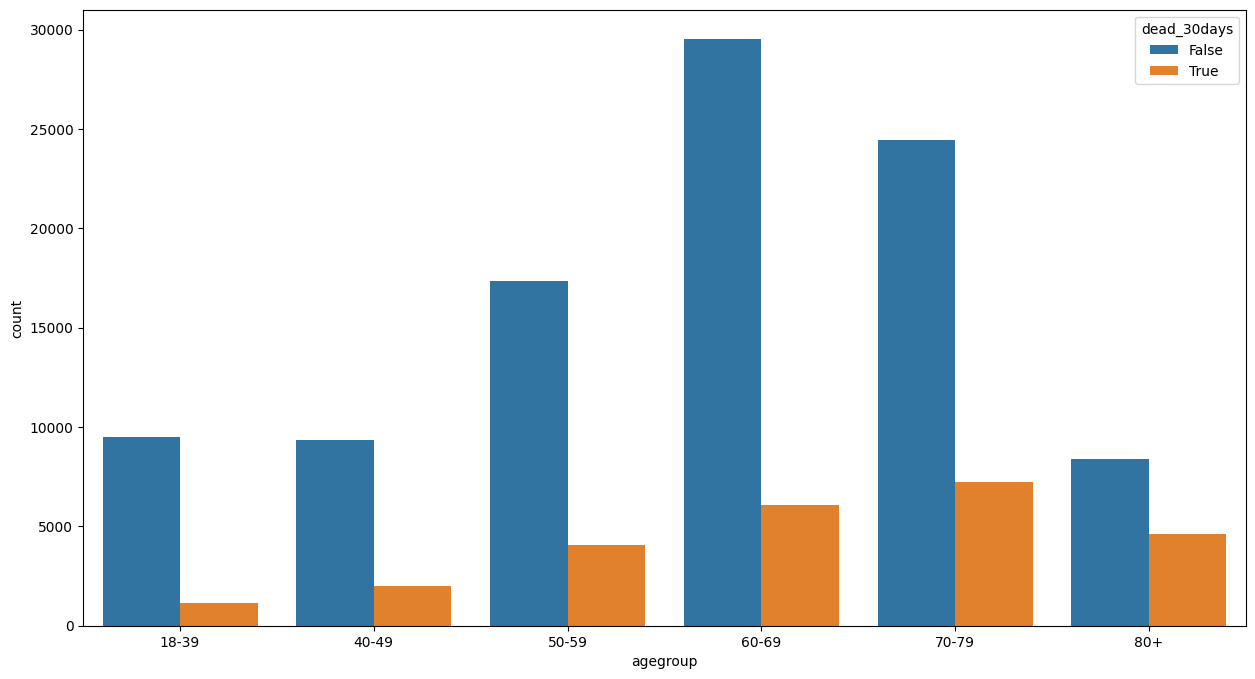

In [ ]:
agegroup_order = ['18-39', '40-49', '50-59', '60-69', '70-79', '80+']

plt.figure(figsize=(15, 8))
sns.countplot(x='agegroup', hue='dead_30days', data=data, order=agegroup_order)
# plt.title('Mortality Rate by Age Group')
plt.show()


### Get dummies

In [ ]:
data = pd.get_dummies(data, columns=cat_columns + ['steroid_name', ])
data.shape

(123667, 83)

In [ ]:
pd.set_option('display.max_columns', 150)

In [ ]:
data.head()

,admissionid,time_bin,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,temp_axil,kreatinine,glucose_bloed,leucocyten,thrombocyten,kalium,natrium_astrup,natrium,laktaat,bili_totaal,hemoglobine,kalium_astrup,sofa_respiration_score,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score,dayofdeath,dead_30days,dead_90days,lengthofstay,last_row,gender_,gender_Man,gender_Vrouw,agegroup_18-39,agegroup_40-49,agegroup_50-59,agegroup_60-69,agegroup_70-79,agegroup_80+,weightgroup_100-109,weightgroup_110+,weightgroup_59-,weightgroup_60-69,weightgroup_70-79,weightgroup_80-89,weightgroup_90-99,heightgroup_159-,heightgroup_160-169,heightgroup_170-179,heightgroup_180-189,heightgroup_190+,diagnosis_subgroup_Abdominaal,diagnosis_subgroup_Algemeen,diagnosis_subgroup_Aorta chirurgie,diagnosis_subgroup_Buikchirurgie,diagnosis_subgroup_CABG en Klepchirurgie,diagnosis_subgroup_Cardio anders,diagnosis_subgroup_Cardiovasculair,diagnosis_subgroup_Endocrinologische chirurgie,diagnosis_subgroup_Hematologisch,diagnosis_subgroup_Infectieziekten,diagnosis_subgroup_KNO/Overige,diagnosis_subgroup_Metabool,diagnosis_subgroup_Orthopedische chirurgie,diagnosis_subgroup_Overige,diagnosis_subgroup_Pulmonaal,diagnosis_subgroup_Pulmonale chirurgie,diagnosis_subgroup_Renaal,diagnosis_subgroup_Transplantatie chirurgie,diagnosis_subgroup_Traumatologie,diagnosis_subgroup_Tumor chirurgie,diagnosis_subgroup_Urogenitaal,diagnosis_subgroup_Vaatchirurgie,diagnosis_subgroup_Vasculair chirurgisch,diagnosis_subgroup_Vasculair neurologisch,steroid_name_Dexamethason,steroid_name_Hydrocortison,steroid_name_Methylprednisolon,steroid_name_Prednisolon,steroid_name_Prednisonum
0,11,0.0,100.0,133.20,94.80,74.50,61.00,94.50,NaN,NaN,337.0,5.80,5.0,132.0,4.6,135.000000,140.0,6.1,NaN,6.300000,4.600000,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,11,1.0,100.0,123.25,96.50,69.75,57.00,96.00,NaN,NaN,337.0,5.10,5.0,132.0,4.6,134.333333,140.0,6.1,NaN,6.633333,4.600000,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,11,2.0,100.0,126.00,96.00,67.00,54.00,95.00,NaN,NaN,337.0,6.60,5.0,132.0,4.6,132.666667,140.0,4.9,NaN,6.733333,4.666667,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,11,3.0,100.0,121.00,105.25,62.25,48.25,97.25,NaN,NaN,302.0,6.30,5.0,98.0,4.8,134.333333,141.0,4.7,27.0,6.625000,4.533333,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,11,4.0,100.0,129.20,108.20,63.60,48.20,98.75,NaN,NaN,302.0,4.65,5.0,98.0,4.8,134.500000,141.0,4.7,27.0,7.200000,4.600000,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
updated_cols = list(data.columns[:-5])

for c in data.columns[-5:]:
  names = str(c).split('_')
  if len(names) < 3:
    updated_cols.append(itemid_to_name[int(names[0])])
  else:
    updated_cols.append(names[-1])

In [ ]:
updated_cols

['admissionid',
 'time_bin',
 'dose',
 'heartrate',
 'sys_BP',
 'mean_BP',
 'dia_BP',
 'saturation',
 'resp_rate',
 'temp_axil',
 'kreatinine',
 'glucose_bloed',
 'leucocyten',
 'thrombocyten',
 'kalium',
 'natrium_astrup',
 'natrium',
 'laktaat',
 'bili_totaal',
 'hemoglobine',
 'kalium_astrup',
 'sofa_respiration_score',
 'sofa_coagulation_score',
 'sofa_liver_score',
 'sofa_cardiovascular_score',
 'sofa_cns_score',
 'sofa_renal_score',
 'sofa_total_score',
 'dayofdeath',
 'dead_30days',
 'dead_90days',
 'lengthofstay',
 'last_row',
 'gender_',
 'gender_Man',
 'gender_Vrouw',
 'agegroup_18-39',
 'agegroup_40-49',
 'agegroup_50-59',
 'agegroup_60-69',
 'agegroup_70-79',
 'agegroup_80+',
 'weightgroup_100-109',
 'weightgroup_110+',
 'weightgroup_59-',
 'weightgroup_60-69',
 'weightgroup_70-79',
 'weightgroup_80-89',
 'weightgroup_90-99',
 'heightgroup_159-',
 'heightgroup_160-169',
 'heightgroup_170-179',
 'heightgroup_180-189',
 'heightgroup_190+',
 'diagnosis_subgroup_Abdominaal',
 '

In [ ]:
data.columns = updated_cols

In [ ]:
data.head()

,admissionid,time_bin,dose,heartrate,sys_BP,mean_BP,dia_BP,saturation,resp_rate,temp_axil,kreatinine,glucose_bloed,leucocyten,thrombocyten,kalium,natrium_astrup,natrium,laktaat,bili_totaal,hemoglobine,kalium_astrup,sofa_respiration_score,sofa_coagulation_score,sofa_liver_score,sofa_cardiovascular_score,sofa_cns_score,sofa_renal_score,sofa_total_score,dayofdeath,dead_30days,dead_90days,lengthofstay,last_row,gender_,gender_Man,gender_Vrouw,agegroup_18-39,agegroup_40-49,agegroup_50-59,agegroup_60-69,agegroup_70-79,agegroup_80+,weightgroup_100-109,weightgroup_110+,weightgroup_59-,weightgroup_60-69,weightgroup_70-79,weightgroup_80-89,weightgroup_90-99,heightgroup_159-,heightgroup_160-169,heightgroup_170-179,heightgroup_180-189,heightgroup_190+,diagnosis_subgroup_Abdominaal,diagnosis_subgroup_Algemeen,diagnosis_subgroup_Aorta chirurgie,diagnosis_subgroup_Buikchirurgie,diagnosis_subgroup_CABG en Klepchirurgie,diagnosis_subgroup_Cardio anders,diagnosis_subgroup_Cardiovasculair,diagnosis_subgroup_Endocrinologische chirurgie,diagnosis_subgroup_Hematologisch,diagnosis_subgroup_Infectieziekten,diagnosis_subgroup_KNO/Overige,diagnosis_subgroup_Metabool,diagnosis_subgroup_Orthopedische chirurgie,diagnosis_subgroup_Overige,diagnosis_subgroup_Pulmonaal,diagnosis_subgroup_Pulmonale chirurgie,diagnosis_subgroup_Renaal,diagnosis_subgroup_Transplantatie chirurgie,diagnosis_subgroup_Traumatologie,diagnosis_subgroup_Tumor chirurgie,diagnosis_subgroup_Urogenitaal,diagnosis_subgroup_Vaatchirurgie,diagnosis_subgroup_Vasculair chirurgisch,diagnosis_subgroup_Vasculair neurologisch,Dexamethason,Hydrocortison,Methylprednisolon,Prednisolon,Prednisonum
0,11,0.0,100.0,133.20,94.80,74.50,61.00,94.50,NaN,NaN,337.0,5.80,5.0,132.0,4.6,135.000000,140.0,6.1,NaN,6.300000,4.600000,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,11,1.0,100.0,123.25,96.50,69.75,57.00,96.00,NaN,NaN,337.0,5.10,5.0,132.0,4.6,134.333333,140.0,6.1,NaN,6.633333,4.600000,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,11,2.0,100.0,126.00,96.00,67.00,54.00,95.00,NaN,NaN,337.0,6.60,5.0,132.0,4.6,132.666667,140.0,4.9,NaN,6.733333,4.666667,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,11,3.0,100.0,121.00,105.25,62.25,48.25,97.25,NaN,NaN,302.0,6.30,5.0,98.0,4.8,134.333333,141.0,4.7,27.0,6.625000,4.533333,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,11,4.0,100.0,129.20,108.20,63.60,48.20,98.75,NaN,NaN,302.0,4.65,5.0,98.0,4.8,134.500000,141.0,4.7,27.0,7.200000,4.600000,2.0,2.0,1.0,4.0,0.0,4.0,13.0,1.544444,True,True,42,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
data.shape

(123667, 83)

In [ ]:
data.admissionid.nunique()

1798

In [ ]:
data.to_csv('processed_data.csv', index=False)